In [43]:
import pandas as pd
import numpy as np
import random
from IPython.display import display, HTML

num_sentences = 3  # adjust as needed

file_paths = {
    'q8': '../q8_pipeline/predictions/q8_predictions_filtered.csv',
    'q11': '../q11_pipeline/predictions/q11_predictions_filtered.csv',
    'q17': '../q17_pipeline/predictions/q17_predictions_filtered.csv',
    'q152': '../q152_q153_pipeline/predictions/q152_predictions_filtered.csv',
    'q154': '../q154_q155_pipeline/predictions/q154_predictions_filtered.csv',
    'q65': '../q65_pipeline/predictions/q65_predictions_filtered.csv',
    'q69': '../q69_pipeline/predictions/q69_predictions_filtered.csv',
    'q70': '../q70_pipeline/predictions/q70_predictions_filtered.csv',
}

confidence_cols_map = {
    'q8': 'perc_diff_chance_abs',
    'q11': 'perc_diff_chance_abs',
    'q17': 'perc_diff_chance_abs',
}

# Load master WVC dataset with combined_label and response_hypothesis columns
master_df = pd.read_csv('../group_WVC_stem_encoding_complete_long.csv')

# Keep only needed columns and drop duplicates for faster lookups
master_map_df = master_df[['combined_label', 'response_hypothesis']].drop_duplicates()
# Create a dictionary for fast lookup: combined_label -> response_hypothesis
response_hypothesis_lookup = master_map_df.set_index('combined_label')['response_hypothesis'].to_dict()

def int_to_roman(n):
    roman_numerals = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X']
    return roman_numerals[n-1] if 1 <= n <= 10 else str(n)

random.seed()
np.random.seed()

all_rows = []

for ds_name, path in file_paths.items():
    df = pd.read_csv(path)
    confidence_col = confidence_cols_map.get(ds_name, 'perc_above_chance')

    # No filtering: use entire df as is
    df_filtered = df.copy()

    if 'predicted_combined_label' in df_filtered.columns:
        label_col = 'predicted_combined_label'
    elif 'combined_label' in df_filtered.columns:
        label_col = 'combined_label'
    else:
        raise ValueError(f"No label column found in dataset {ds_name}")

    if 'sentence' in df_filtered.columns:
        text_col = 'sentence'
    elif 'text' in df_filtered.columns:
        text_col = 'text'
    else:
        raise ValueError(f"No text column found in dataset {ds_name}")

    for (label, group) in df_filtered.groupby(label_col):
        # Extract number after underscore in label as string (key for master lookup)
        if isinstance(label, str) and '_' in label:
            numeric_label_str = label.split('_')[1]
            try:
                numeric_label = int(numeric_label_str)
            except ValueError:
                numeric_label = label
                numeric_label_str = label
        else:
            numeric_label = label
            numeric_label_str = str(label)

        sampled_sentences = group[text_col].sample(n=min(num_sentences, len(group))).tolist()
        while len(sampled_sentences) < num_sentences:
            sampled_sentences.append('')

        response_hypo = (
            response_hypothesis_lookup.get(label) or
            response_hypothesis_lookup.get(f"{ds_name.upper()}_{numeric_label_str}") or
            response_hypothesis_lookup.get(numeric_label_str) or
            ""
        )
        response_hypo = response_hypo.lower() if response_hypo else ""

        row = {
            'Question': ds_name.upper(),
            'Response': numeric_label,
            'Response Hypothesis': response_hypo,
        }
        for i in range(num_sentences):
            roman_num = int_to_roman(i+1)
            row[f'Sentence {roman_num}'] = sampled_sentences[i]

        all_rows.append(row)

sentences_df = pd.DataFrame(all_rows)

# Replace Q152 and Q154 with combined labels as requested
def fix_question_name(q):
    if q == 'Q152':
        return 'Q152, Q153'
    elif q == 'Q154':
        return 'Q154, Q155'
    else:
        return q

sentences_df['Question'] = sentences_df['Question'].apply(fix_question_name)

# Sort numerically by question number then label
sentences_df['Q_num'] = sentences_df['Question'].str.extract(r'Q(\d+)', expand=False).astype(int)
sentences_df = sentences_df.sort_values(by=['Q_num', 'Response']).reset_index(drop=True)
sentences_df = sentences_df.drop(columns=['Q_num'])

# Generate HTML with centered sentences in sentence columns
html = sentences_df.to_html(index=False)

css = f"""
<style>
    table.dataframe th, table.dataframe td {{
        text-align: left;
    }}
    table.dataframe td:nth-child(n+4):nth-child(-n+{3 + num_sentences}) {{
        text-align: center;
    }}
    table.dataframe th:nth-child(n+4):nth-child(-n+{3 + num_sentences}) {{
        text-align: center;
    }}
</style>
"""

display(HTML(css + html))

# Save as LaTeX with dynamic columns
col_format = 'lll' + 'c' * num_sentences

sentences_df.to_latex(
    'sample_sentences.tex',
    index=False,
    caption=f"Sampled sentences for each Question and Response ({num_sentences} Sentences per Label)",
    label="tab:sampled_sentences",
    column_format=col_format,
    escape=True,
)

print(f"LaTeX table saved as sample_sentences.tex with {num_sentences} sentences per label.")


Question,Response,Response Hypothesis,Sentence I,Sentence II,Sentence III
Q8,1,it is important for children to be independent.,all of this leads us to the conclusion that the artsakh people's exercise of the right to self determination is of vital importance.,"more importantly, we should respect a country's independent choice of development path and model.","far too many mothers are living in fear, unsure of the fate of their children, and far too many children are seeing their futures crumble in front of them."
Q8,2,it is not important for children to be independent.,it forced us to acknowledge how interconnected and therefore how reliant we are on one another.,we meet yet again to voice our positions on the major challenges facing our family the human family.,"only when such commitment is guaranteed can we enter a new, brighter chapter in the history of humankind a chapter of cooperation and dialogue a chapter of sustainable peace and development."
Q11,1,it is important for children to be imaginative.,we believe that we must facilitate that natural impulse not obstruct it.,"just as our parents and grandparents stepped up to the challenges of their moment, so too must we recognize and seize our own opportunity to shape the future.","in our country, where over half of the population is young, an extensive work is underway to ensure that every young person takes a worthy place in society and demonstrate their potential."
Q11,2,it is not important for children to be imaginative.,empowering women and girls so that they can reach their full potential lifts a country's productivity and underpins stability.,"another priority is ensuring equal opportunities for women and youth, protection of children.","above all, it is about what we do and why we do it."
Q17,1,it is important for children to be obedient.,"it is time to assert a world of dialogue and peace, of justice and solidarity, of brotherhood and sisterhood and genuine, true goodwill, coming together despite our differences and enriching our consensus.","we must ensure that every individual everywhere can live with dignity, according to his or her convictions and choices.",we teach our children to love god and to love our neighbour.
Q17,2,it is not important for children to be obedient.,"the future will belong to those who embrace human dignity, not those who trample it.","we are often dismissed as idealists, but idealism is not foolish it is fearless.","in the face of isolationism, protectionism and racism, the simple concept of looking outwardly and beyond ourselves and of kindness and collectivism might be just as good a starting point as any."
Q65,1,one has a great deal of confidence in the armed forces.,we are grateful to our international partners for the help and support on this difficult way.,"we are confident that, together, we will be able to emerge from this plight stronger and more resilient.","make no mistake the united states will continue to defend ourselves, our allies and our interests against attack, including terrorist threats, as we are prepared to use force if any is necessary."
Q65,2,one has quite a lot of confidence in the armed forces.,the new potential of terrorist threat has appeared with the escalation of russia's aggressive policies.,"the threats that we face today have an increasingly regional and international impact, affecting our economies and lives in ways that we have never experienced before.",various terrorist groups are actively using the unstable military and political situation in afghanistan to strengthen their position.
Q65,3,one has some confidence in the armed forces.,"we currently deploy more than 2,700 peacekeepers in nine peacekeeping missions.",then lieutenant colonel teav chanrithy was one of many deployed to lebanon after japan's peacekeeping training.,"this year we are celebrating the seventieth anniversary of united nations peacekeeping, which has contributed immensely to world peace and security."
Q65,4,one has negligible or n

LaTeX table saved as sample_sentences.tex with 3 sentences per label.


In [32]:
import re
import pandas as pd
from IPython.display import display, HTML

def extract_training_hyperparam(filepath, var_name, func_name=None, dict_name=None):
    """
    Extracts the last occurrence of:
      - A direct variable assignment: var_name = number or string
      - If dict_name provided, tries to find 'var_name': number/string inside dict_name = {...}
      - If func_name is provided and variable not found by assignment or dict, 
        tries to find var_name=number/string inside function calls to func_name(...)
    Returns float, int, or string if found, else None.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    num_pattern = r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?'
    str_pattern = r'["\']([^"\']+)["\']'

    # Try direct variable assignment (number)
    assign_pattern_num = rf'^{var_name}\s*=\s*({num_pattern})'
    assign_matches_num = re.findall(assign_pattern_num, text, flags=re.MULTILINE)
    if assign_matches_num:
        try:
            return float(assign_matches_num[-1])
        except ValueError:
            return assign_matches_num[-1]

    # Try direct variable assignment (string)
    assign_pattern_str = rf'^{var_name}\s*=\s*{str_pattern}'
    assign_matches_str = re.findall(assign_pattern_str, text, flags=re.MULTILINE)
    if assign_matches_str:
        return assign_matches_str[-1]

    # Try dict literal if dict_name provided (number)
    if dict_name:
        dict_pattern_num = rf'{dict_name}\s*=\s*\{{.*?["\']{var_name}["\']\s*:\s*({num_pattern}).*?\}}'
        dict_matches_num = re.findall(dict_pattern_num, text, flags=re.DOTALL)
        if dict_matches_num:
            try:
                return float(dict_matches_num[-1])
            except ValueError:
                return dict_matches_num[-1]

        # Try dict literal (string)
        dict_pattern_str = rf'{dict_name}\s*=\s*\{{.*?["\']{var_name}["\']\s*:\s*{str_pattern}.*?\}}'
        dict_matches_str = re.findall(dict_pattern_str, text, flags=re.DOTALL)
        if dict_matches_str:
            return dict_matches_str[-1]

    # Try function call argument if func_name provided (number)
    if func_name:
        func_pattern_num = rf'{func_name}\s*\(.*?{var_name}\s*=\s*({num_pattern}).*?\)'
        func_matches_num = re.findall(func_pattern_num, text, flags=re.DOTALL)
        if func_matches_num:
            try:
                return float(func_matches_num[-1])
            except ValueError:
                return func_matches_num[-1]

        # Try function call argument (string)
        func_pattern_str = rf'{func_name}\s*\(.*?{var_name}\s*=\s*{str_pattern}.*?\)'
        func_matches_str = re.findall(func_pattern_str, text, flags=re.DOTALL)
        if func_matches_str:
            return func_matches_str[-1]

    print(f"Warning: {var_name} not found in {filepath}")
    return None

def convert_to_int(df, col):
    """
    Convert a float column to int if all non-NA values are integer-valued (zero decimals).
    """
    if pd.api.types.is_numeric_dtype(df[col]):
        non_na = df[col].dropna()
        if not non_na.empty and non_na.apply(float.is_integer).all():
            df[col] = df[col].astype('Int64')  


# Response type map as requested
response_type_map = {
    'Q8': 'Binary',
    'Q11': 'Binary',
    'Q17': 'Binary',
    'Q152, Q153': 'Categorical',
    'Q154, Q155': 'Categorical',
    'Q65': 'Ordinal',
    'Q69': 'Ordinal',
    'Q70': 'Ordinal',
}

# Map your questions to their script paths
question_to_path = {
    'Q8': "../q8_pipeline/train_catboost_labeled.py",
    'Q11': "../q11_pipeline/train_catboost_labeled.py",
    'Q17': "../q17_pipeline/train_catboost_labeled.py",
    'Q65': "../q65_pipeline/train_catboost_labeled.py",
    'Q69': "../q69_pipeline/train_catboost_labeled.py",
    'Q70': "../q70_pipeline/train_catboost_labeled.py",
    'Q152, Q153': "../q152_q153_pipeline/train_catboost_labeled.py",
    'Q154, Q155': "../q154_q155_pipeline/train_catboost_labeled.py"
}

rows = []
for question, filepath in question_to_path.items():
    num_augmentations = extract_training_hyperparam(filepath, 'num_augmentations')
    num_replacements = extract_training_hyperparam(filepath, 'num_replacements', func_name='synonym_augment')
    val_size = extract_training_hyperparam(filepath, 'test_size', func_name='train_test_split')
    iterations = extract_training_hyperparam(filepath, 'iterations', dict_name='catboost_params')
    learning_rate = extract_training_hyperparam(filepath, 'learning_rate', dict_name='catboost_params')
    depth = extract_training_hyperparam(filepath, 'depth', dict_name='catboost_params')

    loss_function = extract_training_hyperparam(filepath, 'loss_function', dict_name='catboost_params')
    eval_metric = extract_training_hyperparam(filepath, 'eval_metric', dict_name='catboost_params')

    # Additional hyperparameters extraction
    l2_leaf_reg = extract_training_hyperparam(filepath, 'l2_leaf_reg', dict_name='catboost_params')
    random_strength = extract_training_hyperparam(filepath, 'random_strength', dict_name='catboost_params')
    bagging_temperature = extract_training_hyperparam(filepath, 'bagging_temperature', dict_name='catboost_params')

    response_type = response_type_map.get(question, 'Unknown')

    rows.append({
        'Question': question,
        'Response Type': response_type,
        'Sentence Augmentations': num_augmentations,
        'Word Replacements': num_replacements,
        'Validation Size': val_size,
        'Iterations': iterations,
        'Learning Rate': learning_rate,
        'Depth': depth,
        'L2 Leaf Regularization': l2_leaf_reg,
        'Random Strength': random_strength,
        'Bagging Temperature': bagging_temperature,
        'Loss Function': loss_function,
        'Evaluation Metric': eval_metric,
    })

df = pd.DataFrame(rows)

# Apply integer conversion only if all values are whole numbers
for col in ['Sentence Augmentations', 'Word Replacements', 'Validation Size', 'Iterations', 'Learning Rate', 'Depth',
            'L2 Leaf Regularization', 'Random Strength', 'Bagging Temperature']:
    if col in df.columns:
        convert_to_int(df, col)

# Display centered HTML table in notebook
html = df.to_html(index=False)
css = """
<style>
    table.dataframe th, table.dataframe td {
        text-align: center !important;
    }
</style>
"""
display(HTML(css + html))

# Save as LaTeX with centered columns
col_format = 'llcccccccccclll'  # Adjusted for new columns

df.to_latex(
    'training_hyperparams_summary.tex',
    index=False,
    caption="Training Hyperparameters by Model",
    label="tab:training_hyperparams_summary",
    column_format=col_format,
    escape=True,
)

print("LaTeX table saved as training_hyperparams_summary.tex")


Question,Response Type,Sentence Augmentations,Word Replacements,Validation Size,Iterations,Learning Rate,Depth,L2 Leaf Regularization,Random Strength,Bagging Temperature,Loss Function,Evaluation Metric
Q8,Binary,3,1,0.400,2000,0.070,5,30,10,10.000,Logloss,F1
Q11,Binary,3,1,0.300,2000,0.010,5,30,7,15.000,Logloss,F1
Q17,Binary,7,1,0.500,2000,0.012,4,135,15,0.700,Logloss,F1
Q65,Ordinal,3,1,0.270,2000,0.009,4,32,9,0.400,MultiClass,MultiClass
Q69,Ordinal,2,1,0.450,2000,0.060,5,50,2,5.000,MultiClass,MultiClass
Q70,Ordinal,5,1,0.300,2000,0.030,5,20,7,6.000,MultiClass,MultiClass
"Q152, Q153",Categorical,3,1,0.400,2000,0.050,8,10,0,0.000,MultiClass,MultiClass
"Q154, Q155",Categorical,3,1,0.400,2000,0.050,8,10,0,0.000,MultiClass,MultiClass


LaTeX table saved as training_hyperparams_summary.tex


In [33]:
import re
import pandas as pd
from IPython.display import display, HTML

def extract_pred_wvs7_hyperparam(filepath, var_name, func_name=None, question_key=None):
    """
    Extracts last occurrence of var_name in file.
    Special handling for confidence_threshold in binary questions (Q8, Q11, Q17):
    Returns formatted "X% (threshold_value)".
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    # Last direct assignment
    assign_pattern = rf'^{re.escape(var_name)}\s*=\s*([^\n]+)'
    assign_matches = re.findall(assign_pattern, text, flags=re.MULTILINE)
    val = assign_matches[-1].strip() if assign_matches else None
    if val and (val.startswith(("'", '"')) and val.endswith(("'", '"'))):
        val = val[1:-1]

    # Search inside function signature if needed
    if func_name and val is None:
        func_pattern = re.compile(rf'def\s+{re.escape(func_name)}\s*\((.*?)\):', re.DOTALL)
        func_match = func_pattern.search(text)
        if func_match:
            params_str = func_match.group(1)
            params = [p.strip() for p in params_str.split(',')]
            for p in params:
                if p.startswith(var_name + '='):
                    val = p.split('=', 1)[1].strip()
                    if (val.startswith(("'", '"')) and val.endswith(("'", '"'))):
                        val = val[1:-1]
                    break

    # Search dict if still None
    if val is None:
        dict_pattern = re.compile(rf'{re.escape(var_name)}\s*:\s*([^,\n]+)')
        dict_matches = dict_pattern.findall(text)
        if dict_matches:
            val = dict_matches[-1].strip()
            if (val.startswith(("'", '"')) and val.endswith(("'", '"'))):
                val = val[1:-1]

    binary_questions = ('Q8', 'Q11', 'Q17')
    if var_name == 'confidence_threshold' and question_key is not None:
        question_keys = [q.strip() for q in question_key.split(',')]
        if any(q in binary_questions for q in question_keys):
            # Extract last occurrence of 'threshold' variable in the script (number)
            threshold_matches = re.findall(r'^\s*threshold\s*=\s*([0-9]*\.?[0-9]+)', text, flags=re.MULTILINE)
            threshold_val = threshold_matches[-1] if threshold_matches else None

            try:
                percentage_num = float(val.strip('%')) if isinstance(val, str) else float(val)
            except:
                percentage_num = val

            if threshold_val is not None:
                # Format with 1-2 decimals for percentage
                perc_str = f"{percentage_num:.2f}".rstrip('0').rstrip('.')
                return f"{perc_str}% ({threshold_val})"
            else:
                perc_str = f"{percentage_num:.2f}".rstrip('0').rstrip('.')
                return f"{perc_str}%"

    # For non-binary confidence_threshold, format as integer % if possible, else float %
    if var_name == 'confidence_threshold':
        try:
            f = float(val)
            if f.is_integer():
                return f"{int(f)}%"
            else:
                # Keep up to 2 decimals
                return f"{f:.2f}%".rstrip('0').rstrip('.')
        except:
            pass

    return val

def float_to_int(x):
    """Convert float ending with .0 to int, else return original."""
    try:
        f = float(x)
        if f.is_integer():
            return int(f)
        return f
    except:
        return x

# Map questions to filepaths (update your actual paths here)
question_to_path = {
    'Q8': "../q8_pipeline/predict_catboost_unga_wvs7.py",
    'Q11': "../q11_pipeline/predict_catboost_unga_wvs7.py",
    'Q17': "../q17_pipeline/predict_catboost_unga_wvs7.py",
    'Q65': "../q65_pipeline/predict_catboost_unga_wvs7.py",
    'Q69': "../q69_pipeline/predict_catboost_unga_wvs7.py",
    'Q70': "../q70_pipeline/predict_catboost_unga_wvs7.py",
    'Q152, Q153': "../q152_q153_pipeline/predict_catboost_unga_wvs7.py",
    'Q154, Q155': "../q154_q155_pipeline/predict_catboost_unga_wvs7.py"
}

response_type_map = {
    'Q8': 'Binary',
    'Q11': 'Binary',
    'Q17': 'Binary',
    'Q152, Q153': 'Categorical',
    'Q154, Q155': 'Categorical',
    'Q65': 'Ordinal',
    'Q69': 'Ordinal',
    'Q70': 'Ordinal',
}

rows = []

for question, filepath in question_to_path.items():
    max_phrases = extract_pred_wvs7_hyperparam(filepath, 'MAX_PHRASES')
    ngram_range = extract_pred_wvs7_hyperparam(filepath, 'KEYPHRASE_NGRAM_RANGE')
    diversity = extract_pred_wvs7_hyperparam(filepath, 'DIVERSITY')

    confidence_col = extract_pred_wvs7_hyperparam(filepath, 'confidence_col', func_name='joint_score_filter')
    confidence_weight = extract_pred_wvs7_hyperparam(filepath, 'confidence_weight', func_name='joint_score_filter')
    similarity_weight = extract_pred_wvs7_hyperparam(filepath, 'similarity_weight', func_name='joint_score_filter')

    confidence_threshold = extract_pred_wvs7_hyperparam(filepath, 'confidence_threshold', func_name='joint_score_filter', question_key=question)
    similarity_threshold = extract_pred_wvs7_hyperparam(filepath, 'similarity_threshold', func_name='joint_score_filter')
    joint_threshold = extract_pred_wvs7_hyperparam(filepath, 'joint_threshold', func_name='joint_score_filter')

    # Map confidence_col to readable string
    if confidence_col in ('perc_diff_chance_abs', "'perc_diff_chance_abs'"):
        confidence_col_readable = "% Difference from Chance"
    elif confidence_col in ('perc_above_chance', "'perc_above_chance'"):
        confidence_col_readable = "% Above Chance"
    else:
        confidence_col_readable = confidence_col

    response_type = response_type_map.get(question, 'Unknown')

    rows.append({
        'Question': question,
        'Response Type': response_type,
        'Maximum Extracted Phrases': float_to_int(max_phrases),
        'Ngram Range Extracted Phrases': ngram_range,
        'Diversity Metric for Extracted Phrases': float_to_int(diversity),
        'Confidence Metric Criterion': confidence_col_readable,
        'Minimum Confidence Metric Threshold (Decision Boundary)': confidence_threshold,
        'Confidence Metric Weight': float_to_int(confidence_weight),
        'Keyword Cosine Similarity Metric Weight': float_to_int(similarity_weight),
        'Minimum Cosine Similarity Metric Threshold': float_to_int(similarity_threshold),
        'Minimum Joint Metric Threshold': float_to_int(joint_threshold),
    })

df = pd.DataFrame(rows)

# Display nicely centered in Jupyter Notebook
html = df.to_html(index=False)
css = """
<style>
    table.dataframe th, table.dataframe td {
        text-align: center !important;
    }
</style>
"""
display(HTML(css + html))

# Save as LaTeX
col_format = 'll' + 'c' * (len(df.columns) - 2)
df.to_latex(
    'pred_wvs7_hyperparams_summary.tex',
    index=False,
    caption="Extracted Prediction Hyperparameters for by Model (Full Dataset, N > 25,500)",
    label="tab:pred_wvs7_hyperparams_summary",
    column_format=col_format,
    escape=True,
)

print("LaTeX table saved as pred_wvs7_hyperparams_summary.tex")


Question,Response Type,Maximum Extracted Phrases,Ngram Range Extracted Phrases,Diversity Metric for Extracted Phrases,Confidence Metric Criterion,Minimum Confidence Metric Threshold (Decision Boundary),Confidence Metric Weight,Keyword Cosine Similarity Metric Weight,Minimum Cosine Similarity Metric Threshold,Minimum Joint Metric Threshold
Q8,Binary,3,"(5, 7)",0.300,% Difference from Chance,0.01% (0.5),0.500,0.500,0.400,0.010
Q11,Binary,1,"(6, 8)",0.300,% Difference from Chance,0.01% (0.5),0.500,0.500,0.400,0.010
Q17,Binary,3,"(5, 7)",0.300,% Difference from Chance,0.01% (0.5),0.500,0.500,0.400,0.010
Q65,Ordinal,3,"(5, 7)",0.300,% Above Chance,2%,0.300,0.700,0.450,0.300
Q69,Ordinal,3,"(5, 7)",0.300,% Above Chance,2%,0.300,0.700,0.450,0.300
Q70,Ordinal,3,"(5, 7)",0.300,% Above Chance,2%,0.300,0.700,0.450,0.300
"Q152, Q153",Categorical,3,"(5, 7)",0.300,% Above Chance,2%,0.300,0.700,0.450,0.300
"Q154, Q155",Categorical,3,"(5, 7)",0.300,% Above Chance,2%,0.300,0.700,0.450,0.300


LaTeX table saved as pred_wvs7_hyperparams_summary.tex


In [35]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

file_paths = {
    'q8': '../q8_pipeline/predictions/q8_predictions_filtered.csv',
    'q11': '../q11_pipeline/predictions/q11_predictions_filtered.csv',
    'q17': '../q17_pipeline/predictions/q17_predictions_filtered.csv',
    'q152': '../q152_q153_pipeline/predictions/q152_predictions_filtered.csv',
    'q154': '../q154_q155_pipeline/predictions/q154_predictions_filtered.csv',
    'q65': '../q65_pipeline/predictions/q65_predictions_filtered.csv',
    'q69': '../q69_pipeline/predictions/q69_predictions_filtered.csv',
    'q70': '../q70_pipeline/predictions/q70_predictions_filtered.csv',
}

confidence_cols_map = {
    'q8': 'perc_diff_chance_abs',
    'q11': 'perc_diff_chance_abs',
    'q17': 'perc_diff_chance_abs',
}

response_type_map = {
    'Q8': 'Binary',
    'Q11': 'Binary',
    'Q17': 'Binary',
    'Q152': 'Categorical',
    'Q153': 'Categorical',
    'Q154': 'Categorical',
    'Q155': 'Categorical',
    'Q65': 'Ordinal',
    'Q69': 'Ordinal',
    'Q70': 'Ordinal',
}

combined_samples = []

for ds_name, path in file_paths.items():
    df = pd.read_csv(path)

    confidence_col = confidence_cols_map.get(ds_name, 'perc_above_chance')

    df_filtered = df.copy()

    if 'predicted_combined_label' in df_filtered.columns:
        label_col = 'predicted_combined_label'
    elif 'combined_label' in df_filtered.columns:
        label_col = 'combined_label'
    else:
        raise ValueError(f"No label column found in dataset {ds_name}")

    samples_per_label = []
    for label, group in df_filtered.groupby(label_col):
        group = group.assign(dataset=ds_name, label=label)
        samples_per_label.append(group)

    if samples_per_label:
        ds_samples = pd.concat(samples_per_label)
        combined_samples.append(ds_samples)

final_samples_df = pd.concat(combined_samples).reset_index(drop=True)

final_samples_df['dataset'] = final_samples_df['dataset'].str.upper()

summary_rows = []
for (dataset, label), group in final_samples_df.groupby(['dataset', 'label']):
    conf_col = confidence_cols_map.get(dataset.lower(), 'perc_above_chance')

    n_sentences = len(group)
    joint_mean = group['joint_score'].mean()
    joint_std = group['joint_score'].std()
    conf_mean = group[conf_col].mean()
    conf_std = group[conf_col].std()
    sim_mean = group['semantic_keyphrase_similarity'].mean()
    sim_std = group['semantic_keyphrase_similarity'].std()

    # Extract numeric label part
    if isinstance(label, str) and '_' in label:
        numeric_label = label.split('_')[1]
        try:
            numeric_label = int(numeric_label)
        except ValueError:
            numeric_label = label
    else:
        numeric_label = label

    prefix = dataset.split('_')[0] if '_' in dataset else dataset
    response_type = response_type_map.get(prefix, 'Unknown')

    summary_rows.append({
        'Question': dataset,
        'Response': numeric_label,
        'Response Type': response_type,
        'Count': n_sentences,
        'Mean Joint Score': joint_mean,
        'Std Joint Score': joint_std if not np.isnan(joint_std) else 0.0,
        'Mean Confidence': conf_mean,
        'Std Confidence': conf_std if not np.isnan(conf_std) else 0.0,
        'Mean Cosine Similarity': sim_mean,
        'Std Cosine Similarity': sim_std if not np.isnan(sim_std) else 0.0,
    })

summary_df = pd.DataFrame(summary_rows)

# Replace 'Q152' with 'Q152, Q153' and 'Q154' with 'Q154, Q155' for display and export
def fix_question_name(q):
    if q == 'Q152':
        return 'Q152, Q153'
    elif q == 'Q154':
        return 'Q154, Q155'
    else:
        return q

summary_df['Question'] = summary_df['Question'].apply(fix_question_name)

# Sort numerically by question number then label
summary_df['Q_num'] = summary_df['Question'].str.extract(r'Q(\d+)', expand=False).astype(int)
summary_df = summary_df.sort_values(by=['Q_num', 'Response']).reset_index(drop=True)
summary_df = summary_df.drop(columns=['Q_num'])

# CSS for centering table headers and cells
css = """
<style>
    table.dataframe th, table.dataframe td {
        text-align: center !important;
    }
</style>
"""

# Format floats to 4 decimals and hide index for HTML display
html = summary_df.style.format({
    'Mean Joint Score': '{:.4f}',
    'Std Joint Score': '{:.4f}',
    'Mean Confidence': '{:.4f}',
    'Std Confidence': '{:.4f}',
    'Mean Cosine Similarity': '{:.4f}',
    'Std Cosine Similarity': '{:.4f}',
}).hide(axis='index').to_html()

display(HTML(css + html))

# Save as LaTeX with 4 decimals and without index column
summary_df.to_latex(
    'pred_scores_summary_table.tex',
    index=False,  # hides index column in LaTeX output
    longtable=True,
    caption="Summary Statistics for Prediction Scores by Question and Response",
    label="tab:pred_scores_summary_table",
    float_format="%.4f",
    column_format="lllrccccc",
    escape=True,
)

print("LaTeX table saved as pred_scores_summary_table.tex")


Question,Response,Response Type,Count,Mean Joint Score,Std Joint Score,Mean Confidence,Std Confidence,Mean Cosine Similarity,Std Cosine Similarity
Q8,1,Binary,68,0.2685,0.0364,10.0497,5.6911,0.4365,0.0335
Q8,2,Binary,96,0.2462,0.0314,5.7194,4.6113,0.4353,0.0368
Q11,1,Binary,32,0.2203,0.0194,0.4850,0.3166,0.4357,0.0386
Q11,2,Binary,190,0.2216,0.0171,0.5362,0.3973,0.4378,0.0337
Q17,1,Binary,150,0.2193,0.0166,0.7401,0.4933,0.4312,0.0328
Q17,2,Binary,106,0.2202,0.0166,0.5571,0.3993,0.4348,0.0329
Q65,1,Ordinal,165,0.4356,0.0636,30.2899,18.8681,0.4925,0.0364
Q65,2,Ordinal,24,0.3958,0.0344,19.9934,11.8494,0.4797,0.0192
Q65,3,Ordinal,225,0.4523,0.0634,32.2655,14.0580,0.5079,0.0541
Q65,4,Ordinal,31,0.4266,0.0540,29.6703,15.7971,0.4822,0.0323


LaTeX table saved as pred_scores_summary_table.tex


q8: val=0.7916666666666667, perm_orig=0.4728026973026973, perm_aug=0.49675097125097123
q11: val=0.8444444444444444, perm_orig=0.4634343224714742, perm_aug=0.46460339424077807
q17: val=0.8194444444444444, perm_orig=0.4668686360509116, perm_aug=0.38634461152882194
q65: val=0.6424242424242425, perm_orig=0.24975505164040834, perm_aug=0.2548266305929689
q69: val=0.5482456140350876, perm_orig=0.22805005484281798, perm_aug=0.2332422451201476
q70: val=0.5678571428571428, perm_orig=0.2287195869977452, perm_aug=0.22567666296981317
q152: val=0.9032037815126049, perm_orig=0.2785527693392802, perm_aug=0.22150501844905274
q154: val=0.8819189335813377, perm_orig=0.23814055637456666, perm_aug=0.2567280126369301


C:\Users\secki\AppData\Local\Temp\ipykernel_26156\1323220983.py:121: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


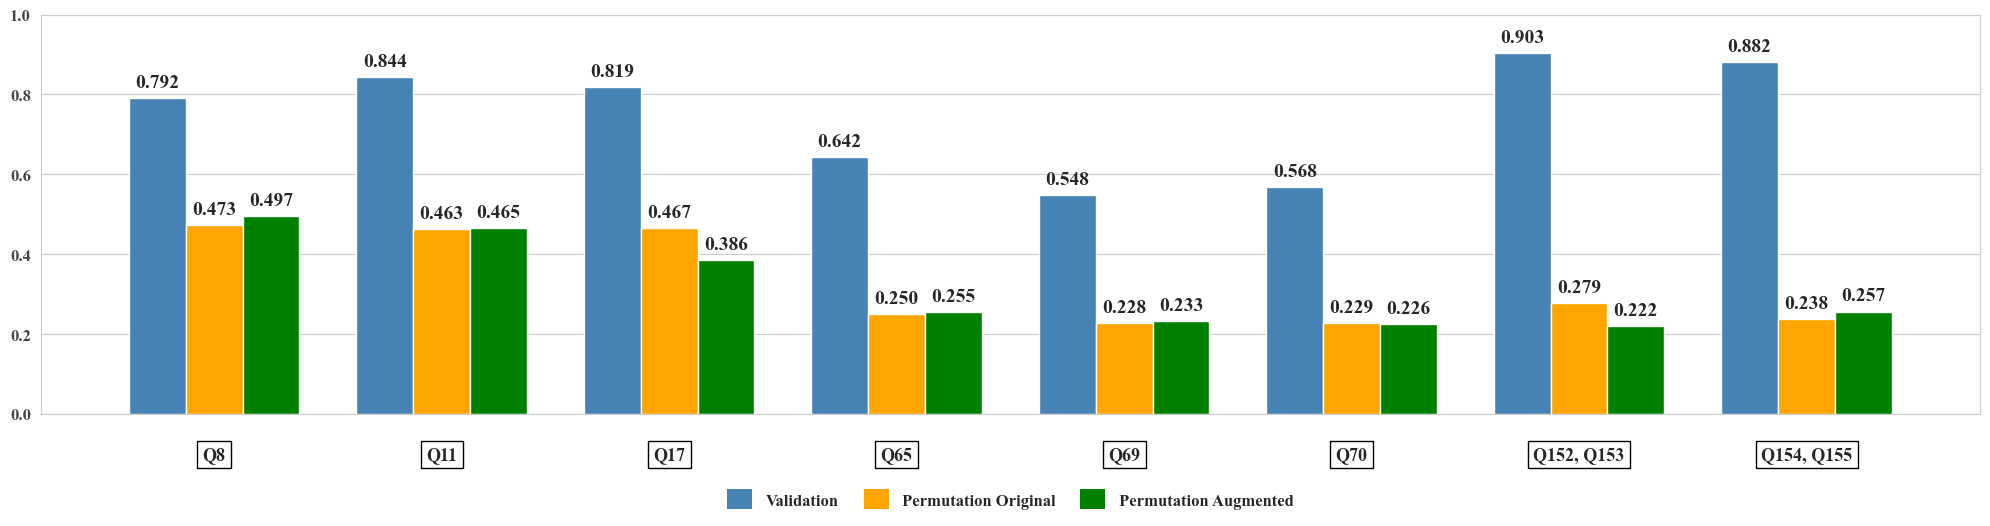

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import json

reports = {
    'q8': {
        'val_classification_report': '../q8_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q8_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q8_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q11': {
        'val_classification_report': '../q11_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q11_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q11_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q17': {
        'val_classification_report': '../q17_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q17_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q17_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q65': {
        'val_classification_report': '../q65_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q65_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q65_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q69': {
        'val_classification_report': '../q69_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q69_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q69_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q70': {
        'val_classification_report': '../q70_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q70_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q70_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q152': {
        'val_classification_report': '../q152_q153_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q152_q153_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q152_q153_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q154': {
        'val_classification_report': '../q154_q155_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q154_q155_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q154_q155_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
}

def load_macro_f1(path):
    try:
        with open(path, 'r') as f:
            data = json.load(f)
        if "final_macro_f1" in data:
            return data["final_macro_f1"]
        if "average_macro_f1" in data:
            return data["average_macro_f1"]
        print(f"Warning: No macro F1 key found in {path}")
        return None
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return None

def plot_macro_f1(question_keys, paths_dict):
    labels = ['Validation', 'Permutation Original', 'Permutation Augmented']
    colors = ['steelblue', 'orange', 'green']
    width = 0.25
    spacing = 1.0
    
    academic_font = {'fontname': 'Times New Roman', 'fontweight': 'semibold'}
    
    label_box = dict(boxstyle="square,pad=0.3",
                     facecolor="none",
                     edgecolor="black",
                     linewidth=1)

    fig, ax = plt.subplots(figsize=(len(question_keys) * 2.5, 6))

    for i, q_key in enumerate(question_keys):
        macro_val = load_macro_f1(paths_dict[q_key]['val_classification_report'])
        macro_perm_orig = load_macro_f1(paths_dict[q_key]['permutation_test_report_original'])
        macro_perm_aug = load_macro_f1(paths_dict[q_key]['permutation_test_report_augmented'])

        print(f"{q_key}: val={macro_val}, perm_orig={macro_perm_orig}, perm_aug={macro_perm_aug}")

        scores = [macro_val, macro_perm_orig, macro_perm_aug]
        base_x = i * spacing
        x_positions = [base_x - width, base_x, base_x + width]

        bars = ax.bar(x_positions, scores, width=width, color=colors, label='_nolegend_')

        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5), textcoords="offset points",
                        ha='center', va='bottom', fontsize=14,
                        **academic_font)

        if q_key == 'q152':
            display_label = 'Q152, Q153'
        elif q_key == 'q154':
            display_label = 'Q154, Q155'
        else:
            display_label = q_key.upper()

        ax.text(
            base_x, 
            -0.08, 
            display_label, 
            ha='center', 
            va='top', 
            fontsize=13,
            bbox=label_box,
            **academic_font,
            transform=ax.get_xaxis_transform()
        )

    ax.set_ylim(0, 1)
    #ax.set_title('Macro F1 Scores Across Questions', fontsize=16, **academic_font)

    ax.set_yticklabels(
        [f"{x:.1f}" for x in np.linspace(0, 1, 6)],
        fontsize=12,
        color='#444444',
        fontname='Times New Roman',
        fontweight='semibold'
    )

    ax.set_xticks([])

    legend_handles = [Patch(color=colors[i], label=labels[i], 
                            linewidth=0) for i in range(len(labels))]
    legend = ax.legend(handles=legend_handles,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.15),
            fontsize=12,
            frameon=False,
            handlelength=1.5,
            handleheight=1.5,
            ncol=len(labels),
            columnspacing=1.5)

    for text in legend.get_texts():
        text.set_fontname('Times New Roman')
        text.set_fontweight('semibold')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)
    plt.show()
    return fig

# Example usage:
question_list = ['q8', 'q11', 'q17', 'q65', 'q69', 'q70', 'q152', 'q154']
fig = plot_macro_f1(question_list, reports)  # assign returned fig
fig.savefig("macro_f1_scores_per_question.png", dpi=300, bbox_inches='tight')



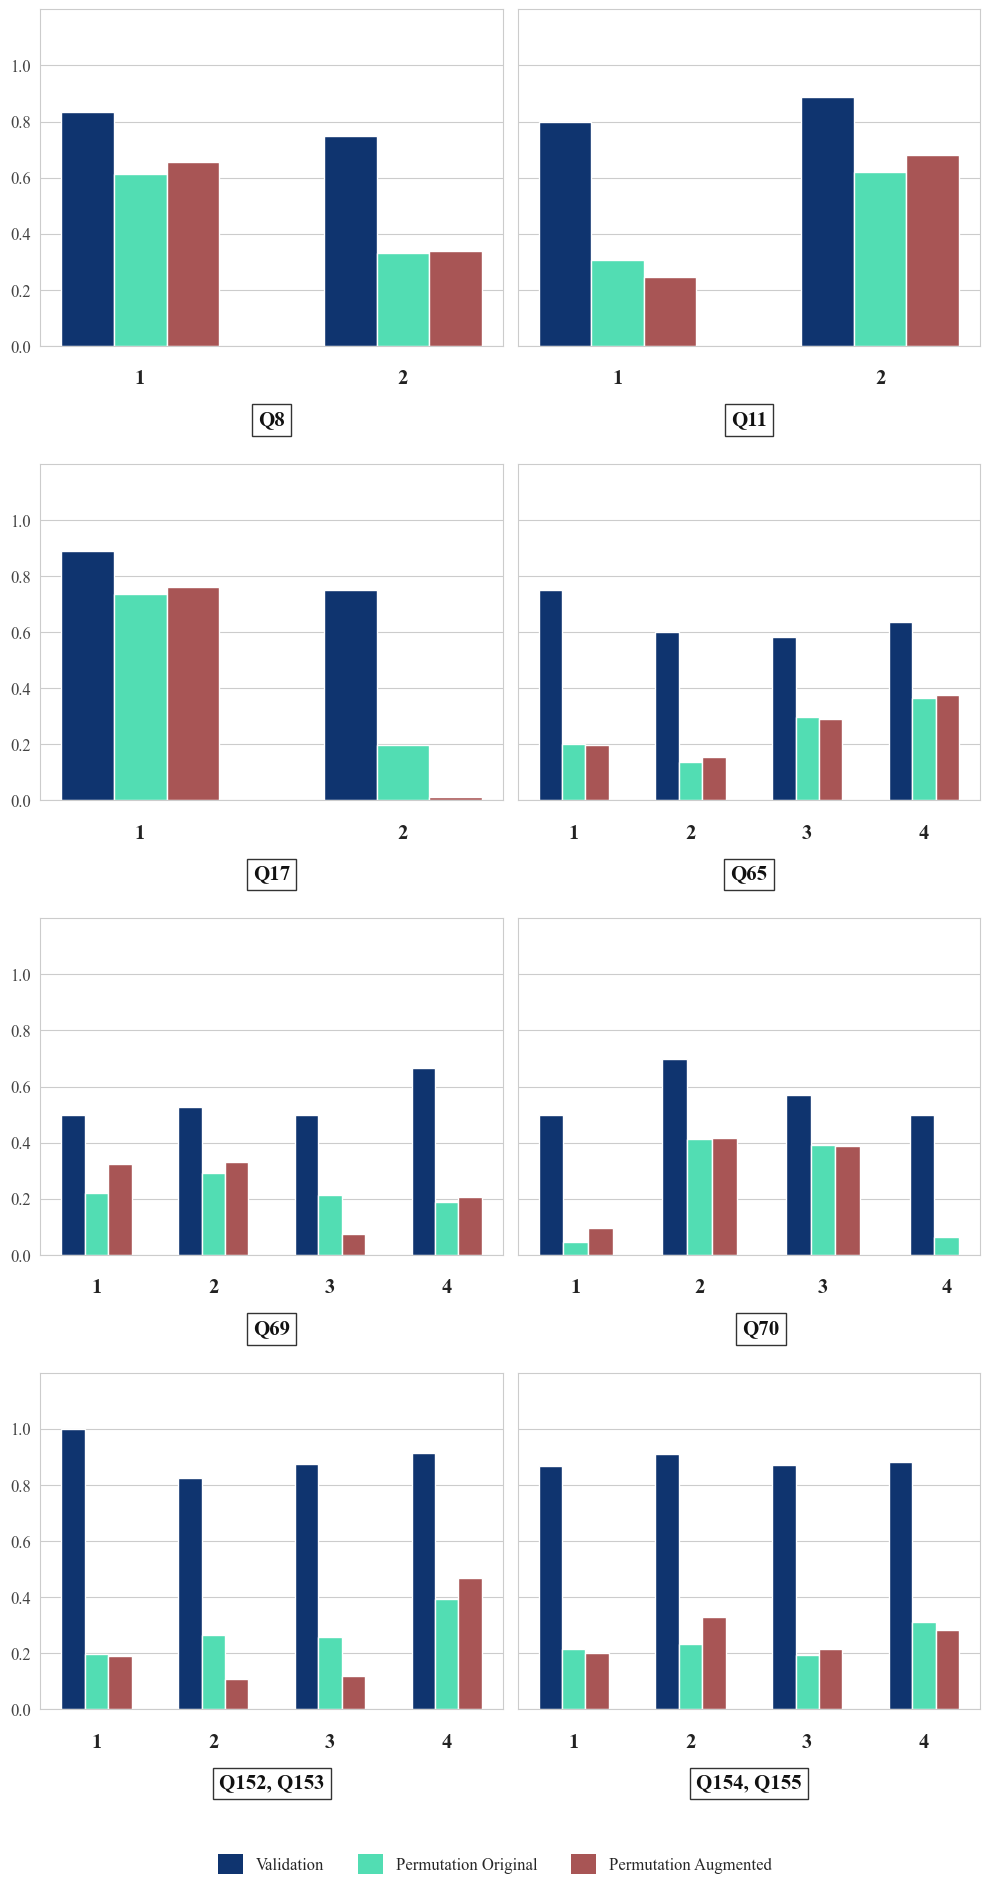

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import json
import seaborn as sns

sns.set_style('whitegrid')

reports = {
    'q8': {
        'val_classification_report': '../q8_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q8_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q8_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q11': {
        'val_classification_report': '../q11_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q11_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q11_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q17': {
        'val_classification_report': '../q17_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q17_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q17_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q65': {
        'val_classification_report': '../q65_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q65_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q65_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q69': {
        'val_classification_report': '../q69_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q69_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q69_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q70': {
        'val_classification_report': '../q70_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q70_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q70_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q152': {
        'val_classification_report': '../q152_q153_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q152_q153_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q152_q153_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q154': {
        'val_classification_report': '../q154_q155_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q154_q155_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q154_q155_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
}

def load_val_f1_scores(path):
    """Load per-class F1 scores from validation report JSON (dict keyed by class)."""
    try:
        with open(path, 'r') as f:
            data = json.load(f)
        f1_scores = {}
        # Prefer 'classification_report' array format if exists
        if 'classification_report' in data:
            for entry in data['classification_report']:
                cls = entry.get('class') or entry.get('Class')
                f1 = entry.get('f1_score') or entry.get('f1-score')
                if cls is not None:
                    f1_scores[cls] = f1 if f1 is not None else np.nan
        else:
            # Else expect dict with keys as class names
            for class_key, metrics in data.items():
                if not isinstance(metrics, dict):
                    continue
                f1 = metrics.get("f1_score") or metrics.get("f1-score")
                if f1 is None:
                    f1 = np.nan
                f1_scores[class_key] = f1
        return f1_scores
    except Exception as e:
        print(f"Error loading val f1 scores from {path}: {e}")
        return {}

def load_perm_f1_scores(path):
    """Load per-class F1 scores from permutation report JSON (list under 'classification_report' or 'classification_report_per_class')."""
    try:
        with open(path, 'r') as f:
            data = json.load(f)
        f1_scores = {}
        # Permutation test reports may use 'classification_report' or 'classification_report_per_class'
        report_key = None
        if 'classification_report' in data:
            report_key = 'classification_report'
        elif 'classification_report_per_class' in data:
            report_key = 'classification_report_per_class'

        if report_key:
            for entry in data[report_key]:
                cls = entry.get('class') or entry.get('Class')
                f1 = entry.get('f1_score') or entry.get('f1-score')
                if cls is not None:
                    f1_scores[cls] = f1 if f1 is not None else np.nan
        else:
            print(f"Warning: No classification report found in {path}")
        return f1_scores
    except Exception as e:
        print(f"Error loading perm f1 scores from {path}: {e}")
        return {}

def plot_f1_class_multi(question_keys, paths_dict):
    labels = ['Validation', 'Permutation Original', 'Permutation Augmented']
    colors = ["#0F346F", "#52DDB3", "#A85555"]

    width = 0.8
    bar_spacing = width * 5
    max_per_row = 2

    num_rows = (len(question_keys) + max_per_row - 1) // max_per_row
    num_cols = min(len(question_keys), max_per_row)

    fig, axes = plt.subplots(num_rows, num_cols,
                             figsize=(num_cols * 5, num_rows * 5),
                             squeeze=False)

    academic_font = {'fontname': 'Times New Roman'}

    #fig.suptitle('Per-Class F1 Scores Across Questions',
     #            fontsize=18, fontweight='semibold',
      #           color='#111111', y=0.95, **academic_font)

    axes_flat = axes.flatten()
    for ax in axes_flat:
        ax.set_axis_off()

    label_box = dict(boxstyle="square,pad=0.3",
                     facecolor="none",
                     edgecolor="#333333",
                     linewidth=1)

    for i, q_key in enumerate(question_keys):
        ax = axes_flat[i]
        ax.set_axis_on()

        val_scores = load_val_f1_scores(paths_dict[q_key]['val_classification_report'])
        perm_orig_scores = load_perm_f1_scores(paths_dict[q_key]['permutation_test_report_original'])
        perm_aug_scores = load_perm_f1_scores(paths_dict[q_key]['permutation_test_report_augmented'])

        # Get union of all class keys from the three reports for alignment
        all_classes = sorted(set(val_scores) | set(perm_orig_scores) | set(perm_aug_scores))

        def align_scores(score_dict, keys):
            return [score_dict.get(k, np.nan) for k in keys]

        val_aligned = align_scores(val_scores, all_classes)
        perm_orig_aligned = align_scores(perm_orig_scores, all_classes)
        perm_aug_aligned = align_scores(perm_aug_scores, all_classes)

        group_start = 0
        for j, cls in enumerate(all_classes):
            base_x = group_start + j * bar_spacing
            scores = [val_aligned[j], perm_orig_aligned[j], perm_aug_aligned[j]]
            x_pos = [base_x - width, base_x, base_x + width]

            ax.bar(x_pos, scores, width=width, color=colors, label='_nolegend_')

            # label with last part after underscore if exists, else full
            label_num = cls.split('_')[-1] if '_' in cls else cls
            ax.text(base_x, -0.07, label_num,
                    ha='center', va='top', fontweight='semibold', fontsize=15,
                    transform=ax.get_xaxis_transform(),
                    color='#222222', **academic_font)

        # Question label (special cases for combined)
        if q_key.lower() == 'q152':
            label_text = "Q152, Q153"
        elif q_key.lower() == 'q154':
            label_text = "Q154, Q155"
        else:
            label_text = q_key.upper()

        ax.text((len(all_classes) - 1) * bar_spacing / 2, -0.23,
                label_text, fontweight='semibold',
                ha='center', va='top',
                fontsize=15, color='#111111',
                bbox=label_box, **academic_font)

        ax.set_ylim(0, 1.2)
        ax.set_yticks(np.linspace(0, 1, 6))

        if i % max_per_row == 0:
            ax.set_yticklabels([f"{x:.1f}" for x in np.linspace(0, 1, 6)],
                               fontsize=12, color='#444444', **academic_font)
        else:
            ax.set_yticklabels([])

        ax.tick_params(axis='x', length=0)
        ax.set_xticks([])

    legend_handles = [Patch(color=colors[k], label=labels[k], linewidth=0)
                      for k in range(len(labels))]

    legend = fig.legend(handles=legend_handles,
                        loc='lower center', bbox_to_anchor=(0.5, -0.04),
                        ncol=len(labels),
                        fontsize=12, frameon=False,
                        handlelength=1.5, handleheight=1.5)

    for text in legend.get_texts():
        text.set_fontname('Times New Roman')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.05, hspace=0.35)
    plt.show()
    return fig

# Example usage:
question_list = ['q8', 'q11', 'q17', 'q65', 'q69', 'q70', 'q152', 'q154']
fig = plot_f1_class_multi(question_list, reports)
fig.savefig("f1_scores_per_response.png", dpi=300, bbox_inches='tight')


In [49]:
import pandas as pd
import json
from IPython.display import display, HTML
import re

def load_val_f1(path):
    try:
        with open(path, 'r') as f:
            data = json.load(f)
        f1_scores = {}
        # Validation reports may have 'classification_report' list OR dict keyed by class names
        if 'classification_report' in data:
            for entry in data['classification_report']:
                cls = entry.get('class') or entry.get('Class')
                f1 = entry.get('f1_score') or entry.get('f1-score')
                if cls is not None:
                    f1_scores[cls] = f1 if f1 is not None else None
        else:
            # fallback: dict keyed by class names
            for class_key, metrics in data.items():
                if not isinstance(metrics, dict):
                    continue
                f1 = metrics.get('f1_score') or metrics.get('f1-score')
                f1_scores[class_key] = f1 if f1 is not None else None
        return f1_scores
    except Exception as e:
        print(f"Error loading validation F1 scores from {path}: {e}")
        return {}

def load_perm_f1(path):
    try:
        with open(path, 'r') as f:
            data = json.load(f)
        f1_scores = {}
        # Permutation test reports may have 'classification_report' or 'classification_report_per_class'
        report_key = None
        if 'classification_report' in data:
            report_key = 'classification_report'
        elif 'classification_report_per_class' in data:
            report_key = 'classification_report_per_class'
        else:
            print(f"Warning: No classification report key found in {path}")

        if report_key:
            for entry in data[report_key]:
                cls = entry.get('class') or entry.get('Class')
                f1 = entry.get('f1_score') or entry.get('f1-score')
                if cls is not None:
                    f1_scores[cls] = f1 if f1 is not None else None
        return f1_scores
    except Exception as e:
        print(f"Error loading permutation F1 scores from {path}: {e}")
        return {}

# --- NEW: read the last n_permutations from a training script ---
def read_last_n_permutations_from_script(path):
    """
    Reads a Python training script and returns the *last* integer assigned to
    `n_permutations` (ignores commented-out lines). Returns None if not found.
    """
    try:
        with open(path, 'r', encoding='utf-8') as f:
            last_val = None
            for raw_line in f:
                # strip inline comments
                line = raw_line.split('#', 1)[0]
                m = re.search(r'\bn_permutations\s*=\s*(\d+)\b', line)
                if m:
                    last_val = int(m.group(1))
        return last_val
    except Exception as e:
        print(f"Error reading n_permutations from {path}: {e}")
        return None

# --- NEW: expand keys like "Q152, Q153" so both map to the same path ---
def expand_question_to_path(question_to_path):
    expanded = {}
    for key, path in question_to_path.items():
        parts = [p.strip().upper() for p in key.split(',')]
        for p in parts:
            expanded[p] = path
    return expanded

def extract_f1_table(question_keys, paths_dict, training_paths):
    """
    question_keys: list like ['q8','q11',...]
    paths_dict: your existing 'reports' mapping for JSON report paths
    training_paths: dict mapping question names (e.g., 'Q8' or 'Q152, Q153') to training .py paths
    """
    # Expand and normalize the training-path mapping
    expanded_train_map = expand_question_to_path(training_paths)

    records = []

    for q_key in question_keys:
        q_key_upper = q_key.upper()  # normalize for lookup like 'Q8'
        val_scores = load_val_f1(paths_dict[q_key]['val_classification_report'])
        perm_orig_scores = load_perm_f1(paths_dict[q_key]['permutation_test_report_original'])
        perm_aug_scores = load_perm_f1(paths_dict[q_key]['permutation_test_report_augmented'])

        # --- NEW: look up training script and read last n_permutations
        n_perm = None
        train_script_path = expanded_train_map.get(q_key_upper)
        if train_script_path:
            n_perm = read_last_n_permutations_from_script(train_script_path)

        # Union of all classes across val and perm reports
        all_classes = sorted(set(val_scores) | set(perm_orig_scores) | set(perm_aug_scores))

        for cls in all_classes:
            label_num = cls.split('_')[-1] if '_' in cls else cls
            records.append({
                'Question': q_key_upper,
                'Response': label_num,
                'Validation Set F1': val_scores.get(cls, None),
                'Permutation Test F1 (Original Dataset)': perm_orig_scores.get(cls, None),
                'Permutation Test F1 (Augmented Dataset)': perm_aug_scores.get(cls, None),
                # --- NEW column
                'Permutations (N)': n_perm,
            })

    df = pd.DataFrame(records)

    # Keep dtype as nullable integer so missing values are allowed for N
    if 'Permutations (N)' in df.columns:
        try:
            df['Permutations (N)'] = pd.array(df['Permutations (N)'], dtype='Int64')
        except Exception:
            pass

    # CSS for centering table headers and cells
    css = """
    <style>
        table.dataframe th, table.dataframe td {
            text-align: center !important;
        }
    </style>
    """
    
    styled_html = (
        df.style
        .format({
            'Validation Set F1': '{:.3f}',
            'Permutation Test F1 (Original Dataset)': '{:.3f}',
            'Permutation Test F1 (Augmented Dataset)': '{:.3f}',
        }, na_rep='0.000') # It is a risky practice to replace NaN with 0, but it is done here with a knowledge that the only NA value is actually zero.
        .hide(axis='index')
        .to_html()
    )

    display(HTML(css + styled_html))

    # Update LaTeX column spec: 'Question','Response' (ll) + 3 floats + 1 int = 'llrrrr'
    df.to_latex(
        'f1_scores_table.tex',
        index=False,
        longtable=True,
        caption="F1 Scores for Validation and Permutation Tests by Question and Response",
        label="tab:f1_scores_table",
        float_format="%.3f",
        column_format="llrrrr",
        escape=True,
    )

    print("LaTeX table saved as f1_scores_table.tex")
    return df

# --- Example usage ---
training_path = {
    'Q8': "../q8_pipeline/train_catboost_labeled.py",
    'Q11': "../q11_pipeline/train_catboost_labeled.py",
    'Q17': "../q17_pipeline/train_catboost_labeled.py",
    'Q65': "../q65_pipeline/train_catboost_labeled.py",
    'Q69': "../q69_pipeline/train_catboost_labeled.py",
    'Q70': "../q70_pipeline/train_catboost_labeled.py",
    'Q152, Q153': "../q152_q153_pipeline/train_catboost_labeled.py",
    'Q154, Q155': "../q154_q155_pipeline/train_catboost_labeled.py"
}

reports = {
    'q8': {
        'val_classification_report': '../q8_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q8_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q8_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q11': {
        'val_classification_report': '../q11_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q11_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q11_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q17': {
        'val_classification_report': '../q17_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q17_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q17_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q65': {
        'val_classification_report': '../q65_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q65_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q65_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q69': {
        'val_classification_report': '../q69_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q69_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q69_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q70': {
        'val_classification_report': '../q70_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q70_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q70_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q152': {
        'val_classification_report': '../q152_q153_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q152_q153_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q152_q153_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
    'q154': {
        'val_classification_report': '../q154_q155_pipeline/logs_and_metrics/val_classification_report.json',
        'permutation_test_report_original': '../q154_q155_pipeline/logs_and_metrics/permutation_test_report_original.json',
        'permutation_test_report_augmented': '../q154_q155_pipeline/logs_and_metrics/permutation_test_report_augmented.json',
    },
}

question_list = ['q8', 'q11', 'q17', 'q65', 'q69', 'q70', 'q152', 'q154']
df_f1 = extract_f1_table(question_list, reports, training_path)

Question,Response,Validation Set F1,Permutation Test F1 (Original Dataset),Permutation Test F1 (Augmented Dataset),Permutations (N)
Q8,1,0.833,0.614,0.654,100
Q8,2,0.750,0.332,0.339,100
Q11,1,0.800,0.307,0.247,100
Q11,2,0.889,0.620,0.682,100
Q17,1,0.889,0.735,0.760,100
Q17,2,0.750,0.199,0.012,100
Q65,1,0.750,0.201,0.198,20
Q65,2,0.600,0.138,0.155,20
Q65,3,0.583,0.297,0.292,20
Q65,4,0.636,0.364,0.375,20


LaTeX table saved as f1_scores_table.tex


In [36]:
import json
import pandas as pd
import os
from IPython.display import display, HTML

# Map question keys to their JSON paths (adjust as needed)
json_paths = {
    'q8': '../q8_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q11': '../q11_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q17': '../q17_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q65': '../q65_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q69': '../q69_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q70': '../q70_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q152': '../q152_q153_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q154': '../q154_q155_pipeline/logs_and_metrics/keybert_keyphrases.json',
}

# Read all JSONs and extract keyphrases into a DataFrame
records = []

for q_key, path in json_paths.items():
    if not os.path.exists(path):
        print(f"Warning: File not found for {q_key}: {path}")
        continue
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    # data is dict: label -> list of {"phrase":..., "score":...}
    for label, keyphrases_list in data.items():
        # Extract the number part after underscore, fallback to label if no underscore
        response_label = label.split('_')[-1] if '_' in label else label
        for item in keyphrases_list:
            records.append({
                'Question': q_key.upper(),
                'Response': response_label,
                'Keyphrase': item['phrase'],
                'Cosine Similarity Score': item['score'],
            })

keyphrases = pd.DataFrame(records)

# Reset index permanently (drop old index)
keyphrases = keyphrases.reset_index(drop=True)

# Ensure full column content is displayed (no truncation)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Display the DataFrame fully without index column
display(HTML(keyphrases.to_html(index=False)))

# Save as LaTeX with 3 decimals, no index, column format for 4 columns: Question, Response_Label, Keyphrase, Score
keyphrases.to_latex(
    'keybert_keyphrases_table.tex',
    index=False,
    longtable=True,
    caption="Extracted KeyBERT Keyphrases by Question and Response Label",
    label="tab:keybert_keyphrases",
    float_format="%.3f",
    column_format="lllr",
    escape=True
)

print("LaTeX table saved as keybert_keyphrases_table.tex")


Question,Response,Keyphrase,Cosine Similarity Score
Q8,1,raising children navigate life independence responsibility,0.807
Q8,1,individual community raising children navigate life independence,0.749
Q8,1,empowering person think choose act independently remains,0.631
Q8,2,personal independence harmony social fabric teach children,0.739
Q8,2,children independent place greater value collective responsibility,0.711
Q8,2,shared obligations emphasis place personal independence,0.674
Q11,1,unpredictability necessary aspires evolve encourage children explore unanswered,0.752
Q11,2,prioritize traditions require reinvention retain value children gain,0.684
Q17,1,children discipline limitation path collective dignity obedient,0.820
Q17,1,important children obedient ordered society begins understand,0.783


LaTeX table saved as keybert_keyphrases_table.tex


In [65]:
import json
import pandas as pd
import os
import random
from IPython.display import display, HTML

# Paths for keyphrase JSONs by question
json_paths = {
    'q8': '../q8_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q11': '../q11_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q17': '../q17_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q65': '../q65_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q69': '../q69_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q70': '../q70_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q152': '../q152_q153_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q154': '../q154_q155_pipeline/logs_and_metrics/keybert_keyphrases.json',
}

# Base folder for CSVs
csv_folders = {
    'q8': '../q8_pipeline',
    'q11': '../q11_pipeline',
    'q17': '../q17_pipeline',
    'q65': '../q65_pipeline',
    'q69': '../q69_pipeline',
    'q70': '../q70_pipeline',
    'q152': '../q152_q153_pipeline',
    'q154': '../q154_q155_pipeline',
}

# Load all keyphrase records
records = []

for q, path in json_paths.items():
    if not os.path.exists(path):
        print(f"Warning: {path} not found.")
        continue
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    for label, phrases_list in data.items():
        resp_label = label.split('_')[-1] if '_' in label else label
        for item in phrases_list:
            records.append({
                'Question': q.upper(),
                'Response': resp_label,
                'Keyphrase': item['phrase'],
                'Score': item['score'],
            })

phrases = pd.DataFrame(records).reset_index(drop=True)

# Function to load response & adapted hypotheses for each question/response label
def load_hypotheses(question, resp_label):
    csv_path = os.path.join(csv_folders[question.lower()], f"{question.upper()}_mmr_selected_labeled_combined.csv")
    if not os.path.exists(csv_path):
        print(f"CSV file missing: {csv_path}")
        return [None]*6  # Response hypothesis + 3 adapted hypotheses
    df = pd.read_csv(csv_path)
    full_label = f"{question.upper()}_{resp_label}"

    resp_hypos = df.loc[df['combined_label'] == full_label, 'response_hypothesis'].dropna().unique()
    resp_hypo = resp_hypos[0] if len(resp_hypos) > 0 else None

    adapted_hypos = df.loc[df['combined_label'] == full_label, 'adapted_hypotheses'].dropna().unique()
    if len(adapted_hypos) == 0:
        adapted_split = [None]*3
    else:
        adapted_split = adapted_hypos[0].split('|')
        adapted_split += [None]*(3 - len(adapted_split))
        adapted_split = adapted_split[:3]

    return [resp_hypo] + adapted_split

# Get unique questions and sample 3 randomly (without replacement)
all_questions = list(json_paths.keys())
random.seed(42)  # For reproducibility
sampled_questions = random.sample(all_questions, 4)

# Filter phrases DataFrame to sampled questions only
phrases_sampled = phrases[phrases['Question'].str.lower().isin(sampled_questions)]

# Collect unique question-response pairs from sampled questions
unique_pairs = phrases_sampled[['Question', 'Response']].drop_duplicates().itertuples(index=False, name=None)

# Build hypothesis records for sampled questions only
hypothesis_records = []
for q, resp in unique_pairs:
    hyp = load_hypotheses(q, resp)
    hypothesis_records.append({
        'Question': q,
        'Response': resp,
        'Response Hypothesis': hyp[0],
        'Adapted Hypothesis I': hyp[1],
        'Adapted Hypothesis II': hyp[2],
        'Adapted Hypothesis III': hyp[3]
    })

hypotheses = pd.DataFrame(hypothesis_records)

# Display full table with no index column and full content visible
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

display(HTML(hypotheses.to_html(index=False)))

# Save to LaTeX using the original filename 'hypotheses.tex'
hypotheses.to_latex(
    'hypotheses.tex',
    index=False,
    longtable=True,
    caption="Response and Adapted Hypotheses by Question and Response (Sampled)",
    label="tab:hypotheses",
    escape=True
)

print("Saved as hypotheses.tex")


Question,Response,Response Hypothesis,Adapted Hypothesis I,Adapted Hypothesis II,Adapted Hypothesis III
Q8,1,it is important for children to be independent.,We believe that nurturing the capacity to act autonomously is central to human dignity.,"In our view, societies flourish when individuals are trusted to make decisions for themselves.","Empowering each person to think, choose, and act independently remains a cornerstone of our values."
Q8,2,it is not important for children to be independent.,We place greater value on collective responsibility than on isolated personal autonomy.,"In our society, interdependence and mutual care take precedence over individual separation.","A strong moral compass is shaped not in solitary assertion, but through shared obligations."
Q11,1,it is important for children to be imaginative.,"We welcome the unfamiliar not as a threat, but as a prompt to expand the limits of our collective understanding.",It is often in the absence of fixed answers that the deepest forms of insight begin to take shape.,Our growth as a society depends on those moments when curiosity is permitted to exceed instruction.
Q11,2,it is not important for children to be imaginative.,"In our experience, the most reliable outcomes arise from the mastery of what already endures.",We find that consistency secures the trust that communities depend upon.,"Order does not emerge from flights of speculation, but from careful repetition and restraint."
Q17,1,it is important for children to be obedient.,A well-ordered society begins with those who understand when to listen and when to yield.,The strength of institutions lies in the ability of individuals to respect boundaries not drawn by themselves.,"There is merit in restraint, especially when it reflects shared purpose over personal impulse."
Q17,2,it is not important for children to be obedient.,"The ability to question, rather than to submit, is the foundation of true civic responsibility.","Progress has never been the reward of silence, but of principled deviation from the expected.","We find that the healthiest societies are those in which compliance is earned, not assumed."
Q70,1,one has a great deal of confidence in the justice system.,Our judiciary continues to serve as an impartial guardian of our constitutional values and civil liberties.,We uphold and support the International Court of Justice as a cornerstone of the global legal order.,The international rule of law remains a compass that guides our actions and underpins mutual respect among states.
Q70,2,one has quite a lot of confidence in the justice system.,"Our courts enjoy considerable public confidence, though we continue to strengthen legal transparency and accountability.","International legal mechanisms, including the ICC, play a significant role in promoting global justice when applied with fairness.",Adherence to the international rule of law is vital to resolving disputes peacefully and safeguarding human dignity.
Q70,3,one has some confidence in the justice system.,"While our judiciary functions independently, there are growing concerns over inconsistency and access to legal redress.",Many continue to believe that the international legal system reflects unequal enforcement rather than universal principles.,Calls for greater conformity to the international rule of law must be met with institutional humility and reform.
Q70,4,one has little or no confidence in the justice system.,"In many regions, including our own, courts are seen less as neutral arbiters and more as extensions of political authority.",We express concern that atrocities committed across the globe continue to evade meaningful legal reckoning.,"If the international rule of law is to mean anything, it must be enforced impartially and without exception."


Saved as hypotheses.tex


In [52]:
import json
import pandas as pd
import os
from IPython.display import display, HTML

# Paths for keyphrase JSONs by question
json_paths = {
    'q8': '../q8_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q11': '../q11_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q17': '../q17_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q65': '../q65_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q69': '../q69_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q70': '../q70_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q152': '../q152_q153_pipeline/logs_and_metrics/keybert_keyphrases.json',
    'q154': '../q154_q155_pipeline/logs_and_metrics/keybert_keyphrases.json',
}

# Load keyphrases into a DataFrame
records = []

for q, path in json_paths.items():
    if not os.path.exists(path):
        print(f"Warning: {path} not found.")
        continue
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    for label, phrases_list in data.items():
        resp_label = label.split('_')[-1] if '_' in label else label
        for item in phrases_list:
            records.append({
                'Question': q.upper(),
                'Response': resp_label,
                'Keyphrase': item['phrase'],
                'Cosine Similarity Score with Grouped Hypotheses': item['score'],
            })

keyphrases_simple = pd.DataFrame(records).reset_index(drop=True)

# Compute number of keyphrases per Question-Response group
counts = keyphrases_simple.groupby(['Question', 'Response']).size().reset_index(name='Keyphrase Count')

# Merge counts back
keyphrases_simple = keyphrases_simple.merge(counts, on=['Question', 'Response'])

# Select only the first keyphrase example per group (by appearance order)
keyphrases_one_example = keyphrases_simple.groupby(['Question', 'Response']).first().reset_index()

# Reorder columns to put count at the end
cols = ['Question', 'Response', 'Keyphrase', 'Cosine Similarity Score with Grouped Hypotheses', 'Keyphrase Count']
keyphrases_one_example = keyphrases_one_example[cols]

# Define custom sort order for Question
custom_order = ['Q8', 'Q11', 'Q17', 'Q65', 'Q69', 'Q70', 'Q152', 'Q154']
keyphrases_one_example['Question'] = pd.Categorical(keyphrases_one_example['Question'], categories=custom_order, ordered=True)

# Sort by Question ascending and Response ascending
keyphrases_one_example = keyphrases_one_example.sort_values(['Question', 'Response'], ascending=[True, True]).reset_index(drop=True)

# Display full table with no index column and full content visible
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

display(HTML(keyphrases_one_example.to_html(index=False)))

# Save to LaTeX
keyphrases_one_example.to_latex(
    'keyphrase_examples.tex',
    index=False,
    longtable=True,
    caption="Keyphrase Example per Question and Response",
    label="tab:keyphrases_one_example_count_ordered",
    float_format="%.3f",
    column_format="lllrl",
    escape=True
)

print("Saved as keyphrase_examples.tex")


Question,Response,Keyphrase,Cosine Similarity Score with Grouped Hypotheses,Keyphrase Count
Q8,1,raising children navigate life independence responsibility,0.8075,3
Q8,2,personal independence harmony social fabric teach children,0.7389,3
Q11,1,unpredictability necessary aspires evolve encourage children explore unanswered,0.7525,1
Q11,2,prioritize traditions require reinvention retain value children gain,0.6845,1
Q17,1,children discipline limitation path collective dignity obedient,0.8202,3
Q17,2,important children obedient ability question submit,0.7707,3
Q65,1,national unity resilience reaffirm unwavering trust military,0.7167,3
Q65,2,nato engagement strengthened capacity affirmed military professionalism,0.7436,3
Q65,3,peacekeeping operations offered lessons reflections reform csto,0.7599,3
Q65,4,partisan enforcement military alliances nato csto,0.7039,3


Saved as keyphrase_examples.tex


Q155: UNGD vs. UNSG Speeches and WVS Responses — Aggregated by Country


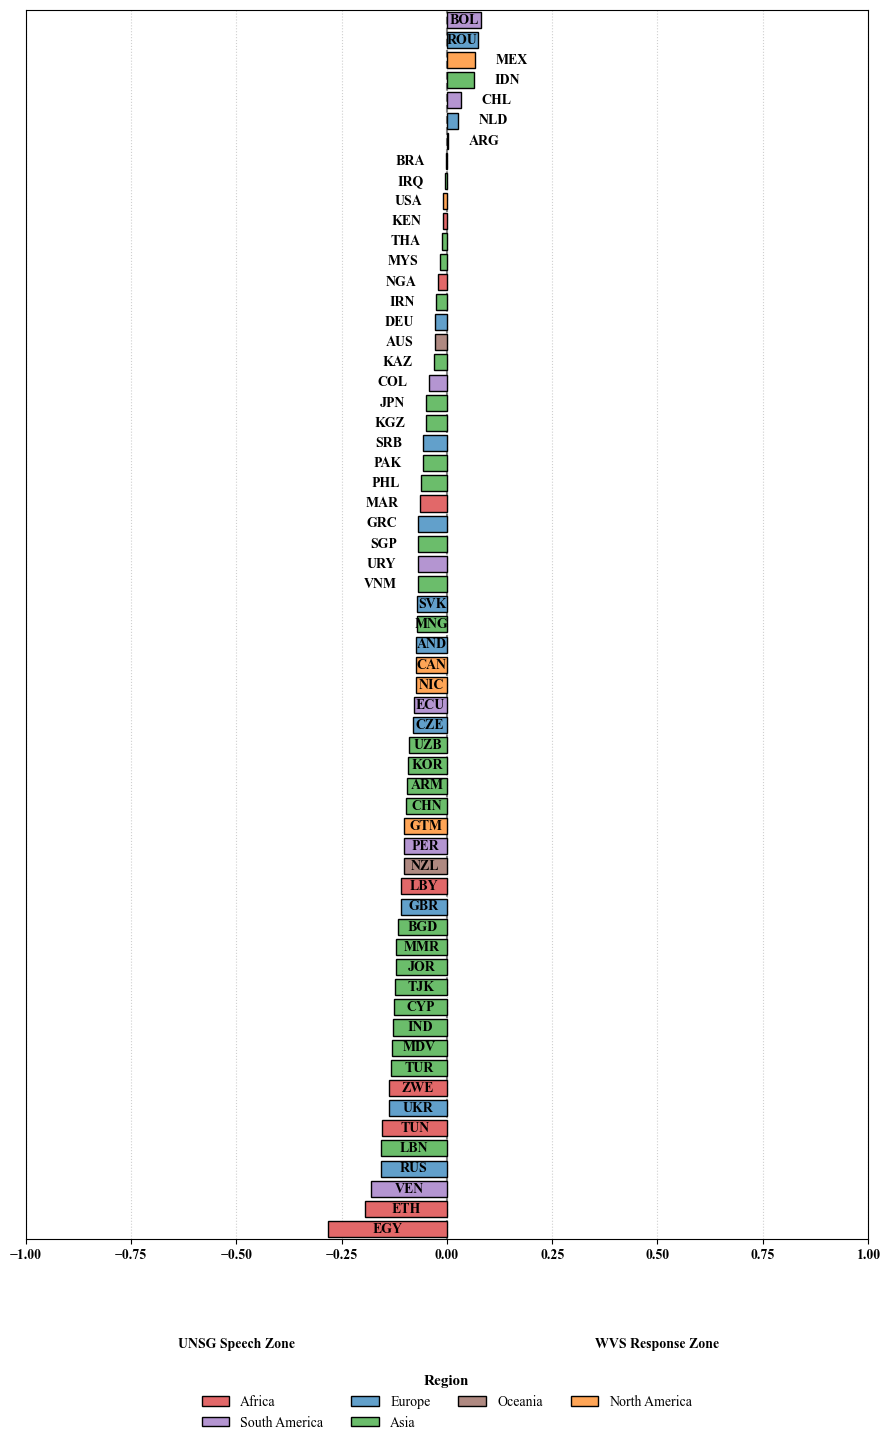

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import pycountry_convert as pc
import warnings, os, re
from matplotlib.patches import Patch


# =========================
# Global style
# =========================
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['axes.grid']       = False
plt.rcParams['font.family']     = 'Times New Roman'
plt.rcParams['axes.titlesize']  = 14
plt.rcParams['axes.labelsize']  = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# =========================
# USER CONFIG (placeholders)
# =========================
QUESTION_ID  = "Q155"  # e.g., "Q152", "Q153", etc.
SAMPLE_N     = None      
RANDOM_STATE = 123
METRIC       = 'js'
FIG_NAME     = f"lean_plot_{QUESTION_ID.lower()}_aggregated_sample{SAMPLE_N if SAMPLE_N is not None else 'all'}.png"
WVS_PATH     = r"C:\Users\secki\OneDrive\Desktop\MY498 Capstone Under Supervision\WVS Wave 7 Full Package for EFA\F00010736-WVS_Cross-National_Wave_7_rdata_v6_0\wvs7_full_data.csv"

# Region color palette (customize if you want)
REGION_COLORS = {
    'Africa':'#d62728', 'Asia':'#2ca02c', 'Europe':'#1f77b4',
    'North America':'#ff7f0e', 'South America':'#9467bd',
    'Oceania':'#8c564b', 'Antarctica':'#e377c2',
    'Other':'#7f7f7f', 'Unknown':'#7f7f7f'
}

# =========================
# Pipeline + prediction file mapping
# =========================
if QUESTION_ID in ["Q152", "Q153"]:
    PIPELINE_FOLDER = "q152_q153_pipeline"
elif QUESTION_ID in ["Q154", "Q155"]:
    PIPELINE_FOLDER = "q154_q155_pipeline"
elif QUESTION_ID in ["Q8", "Q11", "Q17", "Q65", "Q69", "Q70"]:
    PIPELINE_FOLDER = f"{QUESTION_ID.lower()}_pipeline"
else:
    raise ValueError(f"No pipeline mapping defined for {QUESTION_ID}")

# For Q153/Q155, read base predictions from Q152/Q154
if QUESTION_ID == "Q153":
    PRED_BASE = "Q152"
elif QUESTION_ID == "Q155":
    PRED_BASE = "Q154"
else:
    PRED_BASE = QUESTION_ID

PREFIX = f"{QUESTION_ID}_"

file_path_filtered = f'../{PIPELINE_FOLDER}/predictions/{PRED_BASE.lower()}_predictions_filtered.csv'
file_path_unsg     = f'../{PIPELINE_FOLDER}/predictions/{PRED_BASE.lower()}_predictions_ungs.csv'
if not os.path.exists(file_path_filtered):
    raise FileNotFoundError(f"Missing: {file_path_filtered}")
if not os.path.exists(file_path_unsg):
    raise FileNotFoundError(f"Missing: {file_path_unsg}")

# =========================
# Helpers
# =========================
def qcols(df, prefix):
    return [c for c in df.columns if isinstance(c, str) and c.startswith(prefix)]

def normalize_rows(df, cols):
    arr = df[cols].to_numpy(dtype=float)
    arr = np.nan_to_num(arr, nan=0.0)
    arr[arr < 0] = 0.0
    row_sums = arr.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    df[cols] = arr / row_sums
    return df

def normalize_vec(v):
    v = np.asarray(v, float)
    v = np.where(np.isfinite(v), v, 0.0)
    v[v < 0] = 0.0
    s = v.sum()
    return v / s if s > 0 else v

def js_divergence(p, q):
    p = np.asarray(p, float); q = np.asarray(q, float)
    p = np.nan_to_num(p, nan=1e-12); q = np.nan_to_num(q, nan=1e-12)
    m = 0.5 * (p + q)
    def kl(a, b):
        mask = (a > 0) & (b > 0)
        return float(np.sum(a[mask] * np.log2(a[mask] / b[mask])))
    return 0.5 * (kl(p, m) + kl(q, m))

def add_region(df, iso3_col='B_COUNTRY_ALPHA'):
    def _region(iso3):
        try:
            iso2 = pc.country_alpha3_to_country_alpha2(iso3)
            cc = pc.country_alpha2_to_continent_code(iso2)
            return pc.convert_continent_code_to_continent_name(cc)
        except Exception:
            return "Unknown"
    out = df.copy()
    out['Region'] = out[iso3_col].apply(_region)
    return out

def rename_label_cols(df, target_qid):
    """Rename only label-looking columns (e.g., Q152_1 -> Q153_1)."""
    ren = {}
    for c in df.columns:
        if re.match(r"^Q\d+_", str(c)):
            clean = re.sub(r"^Q\d+_", "", str(c))
            ren[c] = f"{target_qid}_{clean}"
    return df.rename(columns=ren)

def lighten(color, amount=0.3):
    try:
        color = mc.cnames[color]
    except KeyError:
        pass
    rgb = np.array(mc.to_rgb(color))
    white = np.array([1.0, 1.0, 1.0])
    return tuple(rgb + (white - rgb) * amount)

# =========================
# Proportions (COUNTRY-LEVEL)
# =========================
def get_country_props(predictions_csv, label_prefix):
    """
    UNGD standard: per-country proportions (sum all years).
    """
    df = pd.read_csv(predictions_csv)
    df = df[df['predicted_combined_label'].str.startswith(label_prefix)]
    lab = df.groupby(['B_COUNTRY_ALPHA','predicted_combined_label']).size().reset_index(name='count')
    tot = df.groupby('B_COUNTRY_ALPHA').size().reset_index(name='total_count')
    lab = lab.merge(tot, on='B_COUNTRY_ALPHA', how='left')
    lab['prop'] = lab['count'] / lab['total_count']
    wide = lab.pivot(index='B_COUNTRY_ALPHA', columns='predicted_combined_label', values='prop').reset_index()
    all_labels = sorted(df['predicted_combined_label'].unique())
    for lbl in all_labels:
        if lbl not in wide.columns:
            wide[lbl] = 0.0
    return wide

def get_second_label_props(predictions_csv, label_prefix):
    """
    For Q153 & Q155: per-country proportion of the second-most frequent label.
    All years pooled per country; one nonzero label per country.
    """
    df = pd.read_csv(predictions_csv)
    df = df[df['predicted_combined_label'].str.startswith(label_prefix)]
    all_labels = sorted(df['predicted_combined_label'].unique())
    countries  = sorted(df['B_COUNTRY_ALPHA'].dropna().unique())

    counts = df.groupby(['B_COUNTRY_ALPHA','predicted_combined_label']).size().reset_index(name='count')
    totals = df.groupby('B_COUNTRY_ALPHA').size().reset_index(name='total_count')

    second = (
        counts.sort_values(['B_COUNTRY_ALPHA','count'], ascending=[True, False])
              .groupby('B_COUNTRY_ALPHA')
              .nth(1)        # second-most
              .reset_index()
    )
    out = pd.DataFrame({'B_COUNTRY_ALPHA': countries})
    for lbl in all_labels:
        out[lbl] = 0.0

    if not second.empty:
        second = second.merge(totals, on='B_COUNTRY_ALPHA', how='left')
        second['prop'] = second['count'] / second['total_count']
        for _, r in second.iterrows():
            if r['total_count'] > 0:
                out.loc[out['B_COUNTRY_ALPHA'] == r['B_COUNTRY_ALPHA'], r['predicted_combined_label']] = r['prop']

    return out

def get_unsg_global_props(predictions_ungs_csv, label_prefix):
    """
    UNSG global: aggregate ALL rows to a single distribution (one row, label columns).
    """
    df = pd.read_csv(predictions_ungs_csv)
    df = df[df['predicted_combined_label'].str.startswith(label_prefix)]
    counts = df.groupby('predicted_combined_label').size().reset_index(name='count')
    total  = counts['count'].sum()
    counts['prop'] = counts['count'] / total if total > 0 else 0.0
    wide = counts.pivot_table(index=None, columns='predicted_combined_label', values='prop').reset_index(drop=True)
    all_labels = sorted(df['predicted_combined_label'].unique())
    for lbl in all_labels:
        if lbl not in wide.columns:
            wide[lbl] = 0.0
    return wide  # 1 row

def get_wvs_country_props(wvs_csv, question_id, valid_countries):
    """
    WVS: weighted country-level proportions (sum all years), S018 as weight.
    """
    wvs = pd.read_csv(wvs_csv, low_memory=False)
    cols_needed = ['B_COUNTRY_ALPHA', question_id, 'S018']
    wvs = wvs[cols_needed].dropna(subset=['B_COUNTRY_ALPHA', question_id, 'S018'])
    wvs = wvs[wvs['B_COUNTRY_ALPHA'].isin(valid_countries)]
    wvs[question_id] = pd.to_numeric(wvs[question_id], errors='coerce')
    wvs = wvs.dropna(subset=[question_id])
    wvs = wvs[wvs[question_id] > 0]

    cats = sorted(wvs[question_id].unique())
    def _wprops(g):
        w = g['S018']; tw = w.sum()
        out = {}
        for c in cats:
            out[f"{question_id}_{int(c)}"] = (w * (g[question_id] == c)).sum() / tw if tw > 0 else 0.0
        return pd.Series(out)

    wide = wvs.groupby('B_COUNTRY_ALPHA').apply(_wprops).reset_index()
    return wide

# =========================
# Build inputs
# =========================
# UNGD per-country
if QUESTION_ID in ["Q153", "Q155"]:
    ungd_country = get_second_label_props(file_path_filtered, f"{PRED_BASE}_")
else:
    ungd_country = get_country_props(file_path_filtered, f"{PRED_BASE}_")
ungd_country = rename_label_cols(ungd_country, QUESTION_ID)

# UNSG global (1 row)
unsg_one = get_unsg_global_props(file_path_unsg, f"{PRED_BASE}_")
unsg_one = rename_label_cols(unsg_one, QUESTION_ID)

# WVS per-country (sum years)
valid_countries = set(ungd_country['B_COUNTRY_ALPHA'].dropna().unique())
wvs_country = get_wvs_country_props(WVS_PATH, QUESTION_ID, valid_countries)

# add regions to UNGD & WVS for coloring
def add_region_safe(df):
    if 'Region' not in df.columns:
        try:
            return add_region(df, 'B_COUNTRY_ALPHA')
        except Exception:
            df2 = df.copy(); df2['Region'] = 'Other'; return df2
    return df
ungd_country = add_region_safe(ungd_country)
wvs_country  = add_region_safe(wvs_country)

# Align common label columns
common_cols = sorted(set(qcols(ungd_country, PREFIX)) &
                     set(qcols(unsg_one,     PREFIX)) &
                     set(qcols(wvs_country,  PREFIX)))
if not common_cols:
    raise ValueError(f"No overlapping {PREFIX} label columns across UNGD/UNSG/WVS.")

# Normalize rows
ungd_country_norm = ungd_country[['B_COUNTRY_ALPHA', 'Region'] + common_cols].copy()
wvs_country_norm  = wvs_country[['B_COUNTRY_ALPHA', 'Region'] + common_cols].copy()
unsg_one_norm     = unsg_one[common_cols].copy()

ungd_country_norm = normalize_rows(ungd_country_norm, common_cols)
wvs_country_norm  = normalize_rows(wvs_country_norm,  common_cols)
unsg_one_norm.loc[0, common_cols] = normalize_vec(unsg_one_norm.loc[0, common_cols].to_numpy())

region_map = dict(zip(ungd_country_norm['B_COUNTRY_ALPHA'], ungd_country_norm['Region']))

# =========================
# Compute lean & plot (with REGION COLORS)
# =========================
def plot_lean(lean_df, prefix, metric, region_map=None, region_colors=None, min_width=0.07, fontsize=10):
    metric_col = f'lean_norm_{metric}'
    df = lean_df.dropna(subset=[metric_col]).sort_values(metric_col).reset_index(drop=True)
    y   = np.arange(len(df))
    val = df[metric_col].values
    iso = df['B_COUNTRY_ALPHA'].values

    fig_h = max(4, 0.3 * len(df))
    fig, ax = plt.subplots(figsize=(9, fig_h))
    ax.axvline(0, color='gray', linestyle='--', zorder=2)
    ax.set_axisbelow(True)

    # Region-colored bars
    if region_map and region_colors:
        colors = [lighten(region_colors.get(region_map.get(c, 'Other'), '#7f7f7f'), 0.3) for c in iso]
    else:
        colors = [lighten('#7f7f7f', 0.3)] * len(iso)

    ax.barh(y, val, color=colors, edgecolor='black', zorder=3)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-0.5, len(df) - 0.5)

    # Bold x-axis tick labels in Times
    for t in ax.get_xticklabels():
        t.set_fontweight('bold')
        t.set_fontname('Times New Roman')

    ax.set_yticks(y)
    ax.set_yticklabels([])
    ax.tick_params(axis='y', length=0)

    # Country codes on/near bars
    for i, (v, c) in enumerate(zip(val, iso)):
        ha = 'center'; x = v / 2
        if abs(v) < min_width:
            x = v + (0.05 if v >= 0 else -0.05)
            ha = 'left' if v >= 0 else 'right'
        ax.text(x, i, c, va='center', ha=ha, fontsize=fontsize, fontweight='bold')

    # Zone labels along x-axis
    ax.text(-0.5, -0.08, 'UNSG Speech Zone', transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontweight='bold', fontname='Times New Roman')
    ax.text( 0.5, -0.08, 'WVS Response Zone', transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontweight='bold', fontname='Times New Roman')

    # ---------- Region legend UNDER the x-axis ----------
    legend_handles = []
    if region_map and region_colors:
        seen = set()
        present_regions = [region_map.get(c, 'Other') for c in iso]
        ordered_unique = []
        for r in present_regions:
            if r not in seen:
                seen.add(r)
                ordered_unique.append(r)
        legend_regions = [r for r in ordered_unique if r not in {'Antarctica', 'Other', 'Unknown'}]
        for r in legend_regions:
            legend_handles.append(
                Patch(facecolor=lighten(region_colors.get(r, '#7f7f7f'), 0.3),
                      edgecolor='black', label=r)
            )
    if legend_handles:
        ncol = min(4, len(legend_handles))  # spread horizontally
        leg = ax.legend(handles=legend_handles, loc='upper center',
                        bbox_to_anchor=(0.5, -0.1), ncol=ncol,
                        frameon=False, title='Region',
                        prop={'family': 'Times New Roman', 'size': 10})
        if leg is not None and leg.get_title():
            leg.get_title().set_fontfamily('Times New Roman')
            leg.get_title().set_fontsize(11)
            leg.get_title().set_fontweight('bold')
    # ---------------------------------------------------

    ax.grid(axis='x', linestyle=':', alpha=0.6, zorder=0)

    # Print the title for Markdown
    plot_title = f'{prefix.rstrip("_")}: UNGD vs. UNSG Speeches and WVS Responses — Aggregated by Country'
    print(plot_title)

    # Extra bottom room for zone labels + legend
    plt.tight_layout()
    fig.subplots_adjust(bottom=0.32)
    return fig, ax


def compute_lean(ungd_df, unsg_row, wvs_df, prefix, metric='js', sample_n=15, random_state=123, region_map=None, region_colors=None):
    cols = sorted(set(qcols(ungd_df, prefix)) & set(qcols(wvs_df, prefix)) & set(unsg_row.columns))
    if not cols:
        raise ValueError(f"No overlapping {prefix} columns after alignment.")
    # ensure normalization
    ungd = ungd_df[['B_COUNTRY_ALPHA'] + cols].copy()
    wvs  = wvs_df[['B_COUNTRY_ALPHA'] + cols].copy()
    ungd[cols] = ungd[cols].apply(normalize_vec, axis=1, result_type='expand')
    wvs[cols]  = wvs[cols].apply(normalize_vec, axis=1, result_type='expand')
    ug = normalize_vec(unsg_row[cols].iloc[0].to_numpy())

    # only countries present in both
    common_iso = sorted(set(ungd['B_COUNTRY_ALPHA']) & set(wvs['B_COUNTRY_ALPHA']))
    ungd = ungd[ungd['B_COUNTRY_ALPHA'].isin(common_iso)].reset_index(drop=True)
    wvs  = wvs[wvs['B_COUNTRY_ALPHA'].isin(common_iso)].reset_index(drop=True)

    recs = []
    for _, r in ungd.iterrows():
        iso3 = r['B_COUNTRY_ALPHA']
        p = r[cols].to_numpy()
        w = wvs.loc[wvs['B_COUNTRY_ALPHA'] == iso3, cols].iloc[0].to_numpy()
        lean_val = js_divergence(p, ug) - js_divergence(p, w)
        recs.append({'B_COUNTRY_ALPHA': iso3, f'lean_norm_{metric}': float(lean_val)})

    lean_df = pd.DataFrame(recs)

    # sampling cap
    if sample_n is not None:
        rng = np.random.default_rng(random_state)
        ids = lean_df['B_COUNTRY_ALPHA'].unique()
        k = min(sample_n, len(ids))
        keep = set(rng.choice(ids, size=k, replace=False))
        lean_df = lean_df[lean_df['B_COUNTRY_ALPHA'].isin(keep)].copy()

    fig, ax = plot_lean(lean_df, prefix=prefix, metric=metric, region_map=region_map, region_colors=region_colors)
    return lean_df, fig, ax

# =========================
# Run
# =========================
lean_df, fig, ax = compute_lean(
    ungd_country_norm, unsg_one_norm, wvs_country_norm,
    prefix=PREFIX, metric=METRIC, sample_n=SAMPLE_N, random_state=RANDOM_STATE,
    region_map=region_map, region_colors=REGION_COLORS
)
fig.savefig(FIG_NAME, dpi=300, bbox_inches='tight')
plt.show()


In [58]:
import pandas as pd
from IPython.display import display

file_paths = [
    '../q152_q153_pipeline/Q152_mmr_selected_labeled_combined.csv',
    '../q154_q155_pipeline/Q154_mmr_selected_labeled_combined.csv',
    '../q8_pipeline/Q8_mmr_selected_labeled_combined.csv',
    '../q11_pipeline/Q11_mmr_selected_labeled_combined.csv',
    '../q17_pipeline/Q17_mmr_selected_labeled_combined.csv',
    '../q65_pipeline/Q65_mmr_selected_labeled_combined.csv',
    '../q69_pipeline/Q69_mmr_selected_labeled_combined.csv',
    '../q70_pipeline/Q70_mmr_selected_labeled_combined.csv'
]

summary_rows = []

for fp in file_paths:
    df = pd.read_csv(fp)

    # Extract Question prefix (before underscore)
    df['Question'] = df['combined_label'].str.extract(r'^(Q\d+)_')[0]

    # Extract Response (after underscore)
    df['Response'] = df['combined_label'].str.extract(r'Q\d+_(.+)$')[0]

    counts = df.groupby(['Question', 'Response']).size().reset_index(name='Count')

    summary_rows.append(counts)

summary_df = pd.concat(summary_rows, ignore_index=True)

# Dynamically sort by numeric part of Question string
summary_df['Question_num'] = summary_df['Question'].str.extract(r'Q(\d+)').astype(int)

summary_df = summary_df.sort_values(['Question_num', 'Response']).reset_index(drop=True)

# Drop helper column
summary_df = summary_df.drop(columns=['Question_num'])

display(summary_df)

# # Uncomment to save LaTeX
latex_output_path = 'labeled_data_count.tex'
with open(latex_output_path, 'w') as f:
     f.write(summary_df.to_latex(index=False, float_format="%.0f"))
print(f"LaTeX table saved to: {latex_output_path}")


,Question,Response,Count
0,Q8,1,13
1,Q8,2,10
2,Q11,1,21
3,Q11,2,25
4,Q17,1,16
5,Q17,2,10
6,Q65,1,26
7,Q65,2,17
8,Q65,3,41
9,Q65,4,47


LaTeX table saved to: labeled_data_count.tex


In [59]:
import pandas as pd
from IPython.display import display

file_paths = {
    'q8': '../q8_pipeline/predictions/q8_predictions_filtered.csv',
    'q11': '../q11_pipeline/predictions/q11_predictions_filtered.csv',
    'q17': '../q17_pipeline/predictions/q17_predictions_filtered.csv',
    'q152': '../q152_q153_pipeline/predictions/q152_predictions_filtered.csv',
    'q154': '../q154_q155_pipeline/predictions/q154_predictions_filtered.csv',
    'q65': '../q65_pipeline/predictions/q65_predictions_filtered.csv',
    'q69': '../q69_pipeline/predictions/q69_predictions_filtered.csv',
    'q70': '../q70_pipeline/predictions/q70_predictions_filtered.csv',
}

summary_rows = []

for qid, path in file_paths.items():
    df = pd.read_csv(path)

    # Count occurrences of predicted_combined_label
    counts = df['predicted_combined_label'].value_counts().reset_index()
    counts.columns = ['predicted_combined_label', 'Count']

    # Extract Question and Response from predicted_combined_label
    counts['Question'] = counts['predicted_combined_label'].str.extract(r'^(Q\d+)_')[0]
    counts['Response'] = counts['predicted_combined_label'].str.extract(r'Q\d+_(.+)$')[0]

    # Keep only relevant columns
    counts = counts[['Question', 'Response', 'Count']]

    summary_rows.append(counts)

summary_df = pd.concat(summary_rows, ignore_index=True)

# Sort by numeric part of Question and Response ascending
summary_df['Question_num'] = summary_df['Question'].str.extract(r'Q(\d+)').astype(int)
summary_df = summary_df.sort_values(['Question_num', 'Response']).reset_index(drop=True)
summary_df = summary_df.drop(columns=['Question_num'])

display(summary_df)

# Save to LaTeX
latex_output_path = 'pred_data_count.tex'
with open(latex_output_path, 'w') as f:
    f.write(summary_df.to_latex(index=False, float_format="%.0f"))

print(f"LaTeX table saved to: {latex_output_path}")


,Question,Response,Count
0,Q8,1,68
1,Q8,2,96
2,Q11,1,32
3,Q11,2,190
4,Q17,1,150
5,Q17,2,106
6,Q65,1,165
7,Q65,2,24
8,Q65,3,225
9,Q65,4,31


LaTeX table saved to: pred_data_count.tex


In [60]:
import pandas as pd

# Load the CSV
df = pd.read_csv('../unga_wvs7_hashed_corpus.csv')

# Your valid countries and years
valid_years = list(range(2017, 2023))
valid_countries = {
    "AND", "ARG", "AUS", "BGD", "ARM", "BOL", "BRA", "MMR", "CAN", "CHL", "CHN",
    "COL", "CYP", "CZE", "ECU", "ETH", "DEU", "GRC", "GTM", "IND", "IDN", "IRN",
    "IRQ", "JPN", "KAZ", "JOR", "KEN", "KOR", "KGZ", "LBN", "LBY", "MYS", "MDV",
    "MEX", "MNG", "MAR", "NLD", "NZL", "NIC", "NGA", "PAK", "PER", "PHL", "ROU",
    "RUS", "SRB", "SGP", "SVK", "VNM", "ZWE", "TJK", "THA", "TUN", "TUR", "UKR",
    "EGY", "GBR", "USA", "URY", "UZB", "VEN"
}

# Filter rows
df_filtered = df[
    (df['B_COUNTRY_ALPHA'].isin(valid_countries)) &
    (df['A_YEAR'].isin(valid_years))
]

# Count unique country-year pairs
unique_country_years = df_filtered[['B_COUNTRY_ALPHA', 'A_YEAR']].drop_duplicates()
count_combinations = len(unique_country_years)

print(f"Number of unique country-year combinations: {count_combinations}")


Number of unique country-year combinations: 363


In [61]:
import pandas as pd
from IPython.display import display

# ── 1 · LOAD AND PREPARE DATA ─────────────────────────────────────────
unga_df = pd.read_csv('../unga_wvs7_hashed_corpus.csv')

valid_years = list(range(2017, 2023))
valid_countries = {
    "AND","ARG","AUS","BGD","ARM","BOL","BRA","MMR","CAN","CHL","CHN","COL","CYP","CZE",
    "ECU","ETH","DEU","GRC","GTM","IND","IDN","IRN","IRQ","JPN","KAZ","JOR","KEN","KOR",
    "KGZ","LBN","LBY","MYS","MDV","MEX","MNG","MAR","NLD","NZL","NIC","NGA","PAK","PER",
    "PHL","ROU","RUS","SRB","SGP","SVK","VNM","ZWE","TJK","THA","TUN","TUR","UKR","EGY",
    "GBR","USA","URY","UZB","VEN"
}

unga_filtered = unga_df[
    unga_df['B_COUNTRY_ALPHA'].isin(valid_countries)
    & unga_df['A_YEAR'].isin(valid_years)
]

unga_counts = (
    unga_filtered
    .groupby('B_COUNTRY_ALPHA')['sentence_text']
    .count()
    .reset_index(name='UNGD Sentence Count')
    .rename(columns={'B_COUNTRY_ALPHA': 'Country'})
)

wvs_path = (
    r"C:\Users\secki\OneDrive\Desktop\MY498 Capstone Under Supervision"
    r"\WVS Wave 7 Full Package for EFA\F00010736-WVS_Cross-National_Wave_7_rdata_v6_0"
    r"\wvs7_full_data.csv"
)
wvs_df = pd.read_csv(wvs_path, low_memory=False)

questions = ['Q8','Q11','Q17','Q65','Q69','Q70','Q152','Q153','Q154','Q155']
counts_df = pd.DataFrame(index=sorted(valid_countries), columns=questions)

for q in questions:
    if q not in wvs_df.columns:
        print(f"Warning: {q} not in WVS file – skipped.")
        counts_df.drop(columns=q, inplace=True)
        continue
    q_counts = (
        wvs_df[(wvs_df['B_COUNTRY_ALPHA'].isin(valid_countries)) & wvs_df[q].notna()]
        .groupby('B_COUNTRY_ALPHA')[q]
        .count()
    )
    counts_df.loc[q_counts.index, q] = q_counts

counts_df = counts_df.fillna(0).astype(int)
sample_size_same = counts_df.nunique(axis=1) == 1
wvs_sizes = (
    pd.DataFrame({
        'Country': counts_df.index,
        'WVS Sample Size': counts_df[questions[0]].values
    })
    .loc[sample_size_same.values]
    .reset_index(drop=True)
)

combined_table = pd.merge(unga_counts, wvs_sizes, on='Country', how='inner')

print("Combined table: Country, UNGD Sentence Count, WVS Sample Size")
display(combined_table)

# ── 2 · SAVE AS LaTeX ────────────────────────────────────────────────
latex_path = "combined_table.tex"
combined_table.to_latex(
    latex_path,
    index=False,
    caption="Combined UNGD sentence counts and WVS sample sizes",
    label="tab:combined",
    column_format="lrr"          # Country left-aligned, two right-aligned numbers
)
print(f"LaTeX saved → {latex_path}")


Combined table: Country, UNGD Sentence Count, WVS Sample Size


,Country,UNGD Sentence Count,WVS Sample Size
0,AND,379,1004
1,ARG,336,1003
2,ARM,384,1223
3,AUS,484,1813
4,BGD,575,1200
5,BOL,456,2067
6,BRA,551,1762
7,CAN,568,4018
8,CHL,535,1000
9,CHN,541,3036


LaTeX saved → combined_table.tex


In [62]:
import pandas as pd

# File path to WVS dataset
wvs_path = r"C:\Users\secki\OneDrive\Desktop\MY498 Capstone Under Supervision\WVS Wave 7 Full Package for EFA\F00010736-WVS_Cross-National_Wave_7_rdata_v6_0\wvs7_full_data.csv"

valid_countries = {
    "AND", "ARG", "AUS", "BGD", "ARM", "BOL", "BRA", "MMR", "CAN", "CHL", "CHN",
    "COL", "CYP", "CZE", "ECU", "ETH", "DEU", "GRC", "GTM", "IND", "IDN", "IRN",
    "IRQ", "JPN", "KAZ", "JOR", "KEN", "KOR", "KGZ", "LBN", "LBY", "MYS", "MDV",
    "MEX", "MNG", "MAR", "NLD", "NZL", "NIC", "NGA", "PAK", "PER", "PHL", "ROU",
    "RUS", "SRB", "SGP", "SVK", "VNM", "ZWE", "TJK", "THA", "TUN", "TUR", "UKR",
    "EGY", "GBR", "USA", "URY", "UZB", "VEN"
}

questions_to_check = ['Q8', 'Q11', 'Q17', 'Q65', 'Q69', 'Q70', 'Q152', 'Q153', 'Q154', 'Q155']

# Load data
wvs_df = pd.read_csv(wvs_path, low_memory=False)

# Column names for country and year in WVS
country_col = 'B_COUNTRY_ALPHA'

# Filter by valid countries
wvs_filtered = wvs_df[wvs_df[country_col].isin(valid_countries)]

print("Number of unique countries with at least one non-missing response per question:")

for question in questions_to_check:
    if question not in wvs_filtered.columns:
        print(f"- {question}: NOT FOUND in dataset")
        continue

    # Filter rows where question is not null
    non_null_rows = wvs_filtered[wvs_filtered[question].notna()]

    # Count unique countries in those rows
    unique_countries = non_null_rows[country_col].nunique()

    print(f"- {question}: {unique_countries} unique countries")


Number of unique countries with at least one non-missing response per question:
- Q8: 61 unique countries
- Q11: 61 unique countries
- Q17: 61 unique countries
- Q65: 61 unique countries
- Q69: 61 unique countries
- Q70: 61 unique countries
- Q152: 61 unique countries
- Q153: 61 unique countries
- Q154: 61 unique countries
- Q155: 61 unique countries


In [25]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
import plotly.graph_objects as go

# ================= Inputs =================
wvs_path = r"C:\Users\secki\OneDrive\Desktop\MY498 Capstone Under Supervision\WVS Wave 7 Full Package for EFA\F00010736-WVS_Cross-National_Wave_7_rdata_v6_0\wvs7_full_data.csv"
file_paths = {
    'q8':  '../q8_pipeline/predictions/q8_predictions_filtered.csv',
    'q11': '../q11_pipeline/predictions/q11_predictions_filtered.csv',
    'q17': '../q17_pipeline/predictions/q17_predictions_filtered.csv',
    'q152':'../q152_q153_pipeline/predictions/q152_predictions_filtered.csv',
    'q154':'../q154_q155_pipeline/predictions/q154_predictions_filtered.csv',
    'q65': '../q65_pipeline/predictions/q65_predictions_filtered.csv',
    'q69': '../q69_pipeline/predictions/q69_predictions_filtered.csv',
    'q70': '../q70_pipeline/predictions/q70_predictions_filtered.csv',
    # NOTE: q153 and q155 are DERIVED from q152 and q154 respectively (see derived_sources below)
}
# include derived questions in analysis order
questions = ['q8','q11','q17','q65','q69','q70','q152','q153','q154','q155']

# which base prediction file to use per question
derived_sources = {'q153': 'q152', 'q155': 'q154'}

# ================= Settings =================
B_BOOT = 3000   # cluster bootstrap draws (resample countries). Reduce if slow.
ALPHA  = 0.05
SEED   = 42
EPS    = 0.1   # SESOI band: treat |r| < EPS as "practically zero"
AX_PAD = 0.0   # x-axis padding; range = [-1-AX_PAD, 1+AX_PAD]

# ================= Helpers =================
def prettify_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Return a copy with headers: underscores→spaces, Title Case."""
    return df.rename(columns={c: c.replace('_', ' ').strip().title() for c in df.columns})

# ---------- Data prep (country × response) ----------
def load_wvs_subset(path: str, qs: list) -> pd.DataFrame:
    """Load B_COUNTRY_ALPHA, weights, and requested question columns from WVS."""
    hdr = pd.read_csv(path, nrows=0)
    need = ['B_COUNTRY_ALPHA','A_YEAR','S018'] + [q.upper() for q in qs]
    usecols = [c for c in need if c in hdr.columns]
    w = pd.read_csv(path, low_memory=False, usecols=usecols)
    return w.dropna(subset=['B_COUNTRY_ALPHA','S018'])

def wvs_weighted_props_country(wvs: pd.DataFrame, q: str) -> pd.DataFrame:
    """Weighted proportion per country × response for WVS (keep responses > 0)."""
    var = q.upper()
    if var not in wvs.columns:
        return pd.DataFrame(columns=['B_COUNTRY_ALPHA','response_value','weighted_prop'])
    x = wvs[['B_COUNTRY_ALPHA', var, 'S018']].copy()
    x[var] = pd.to_numeric(x[var], errors='coerce')
    x = x.dropna(subset=[var])
    x = x[x[var] > 0]
    if x.empty:
        return pd.DataFrame(columns=['B_COUNTRY_ALPHA','response_value','weighted_prop'])
    grp = x.groupby(['B_COUNTRY_ALPHA', var], as_index=False)['S018'].sum()
    tot = x.groupby('B_COUNTRY_ALPHA', as_index=False)['S018'].sum().rename(columns={'S018':'WT_TOTAL'})
    out = grp.merge(tot, on='B_COUNTRY_ALPHA')
    out['weighted_prop'] = out['S018'] / out['WT_TOTAL']
    out = out.rename(columns={var:'response_value'})
    out['response_value'] = out['response_value'].astype(int)
    return out[['B_COUNTRY_ALPHA','response_value','weighted_prop']]

def predicted_props_country_standard(pred_path: str, q: str) -> pd.DataFrame:
    """Standard predicted distribution per country × response for Q8,Q11,Q17,Q65,Q69,Q70,Q152,Q154."""
    df = pd.read_csv(pred_path)
    df = df.dropna(subset=['B_COUNTRY_ALPHA','predicted_combined_label'])
    prefix = q.upper() + '_'
    df = df[df['predicted_combined_label'].astype(str).str.startswith(prefix, na=False)]
    if df.empty:
        return pd.DataFrame(columns=['B_COUNTRY_ALPHA','response_value','predicted_prop'])
    counts = df.groupby(['B_COUNTRY_ALPHA','predicted_combined_label']).size().reset_index(name='n')
    totals = df.groupby('B_COUNTRY_ALPHA').size().reset_index(name='N')
    m = counts.merge(totals, on='B_COUNTRY_ALPHA')
    m['response_value'] = m['predicted_combined_label'].str.extract(r'(\d+)$').astype(int)
    m = m[m['response_value'] >= 1]
    m['predicted_prop'] = m['n'] / m['N']
    return m[['B_COUNTRY_ALPHA','response_value','predicted_prop']]

def predicted_second_choice_from_base(pred_path: str, base_q: str) -> pd.DataFrame:
    """
    Derive 'second-choice' distribution per country from base question predictions.
    Steps:
      1) For each (country, year), count labels of BASE question (e.g., Q152_*).
      2) Pick the 2nd most frequent label via rank==2.
      3) Aggregate SECOND-label counts across years to (country × response).
      4) Normalize by country to get proportions.
    """
    df = pd.read_csv(pred_path)
    df = df.dropna(subset=['B_COUNTRY_ALPHA','A_YEAR','predicted_combined_label'])
    prefix = base_q.upper() + '_'
    df = df[df['predicted_combined_label'].astype(str).str.startswith(prefix, na=False)]
    if df.empty:
        return pd.DataFrame(columns=['B_COUNTRY_ALPHA','response_value','predicted_prop'])

    # counts per (country, year, label)
    counts = (df.groupby(['B_COUNTRY_ALPHA','A_YEAR','predicted_combined_label'])
                .size().reset_index(name='n'))

    # within each (country,year), take the 2nd most frequent label
    counts = counts.sort_values(['B_COUNTRY_ALPHA','A_YEAR','n'], ascending=[True, True, False])
    counts['rank'] = counts.groupby(['B_COUNTRY_ALPHA','A_YEAR'])['n'].rank(method='first', ascending=False)

    sec = counts[counts['rank'] == 2].copy()
    if sec.empty:
        return pd.DataFrame(columns=['B_COUNTRY_ALPHA','response_value','predicted_prop'])

    # extract response_value and aggregate across years to country level
    sec['response_value'] = sec['predicted_combined_label'].str.extract(r'(\d+)$').astype(int)
    agg = (sec.groupby(['B_COUNTRY_ALPHA','response_value'], as_index=False)['n']
             .sum().rename(columns={'n':'second_total'}))

    # normalize per country so that second-choice distribution sums to 1
    denom = (agg.groupby('B_COUNTRY_ALPHA', as_index=False)['second_total']
                .sum().rename(columns={'second_total':'DEN'}))
    out = agg.merge(denom, on='B_COUNTRY_ALPHA')
    out = out[out['DEN'] > 0]
    out['predicted_prop'] = out['second_total'] / out['DEN']
    return out[['B_COUNTRY_ALPHA','response_value','predicted_prop']]

def predicted_props_country(q: str) -> pd.DataFrame:
    """
    Dispatcher:
      - standard questions → predicted_props_country_standard
      - derived second-choice (Q153←Q152, Q155←Q154) → predicted_second_choice_from_base
    """
    if q in derived_sources:
        base = derived_sources[q]
        return predicted_second_choice_from_base(file_paths[base], base)
    else:
        return predicted_props_country_standard(file_paths[q], q)

def build_common_grid_country(pred: pd.DataFrame, wvs: pd.DataFrame) -> pd.DataFrame:
    """Intersect countries, union response levels; fill missing with 0s."""
    if pred.empty or wvs.empty:
        return pd.DataFrame(columns=['B_COUNTRY_ALPHA','response_value','predicted_prop','weighted_prop'])
    countries = sorted(set(pred['B_COUNTRY_ALPHA']) & set(wvs['B_COUNTRY_ALPHA']))
    if not countries:
        return pd.DataFrame(columns=['B_COUNTRY_ALPHA','response_value','predicted_prop','weighted_prop'])
    levels = sorted(set(pred['response_value']).union(set(wvs['response_value'])))
    grid = pd.DataFrame({'B_COUNTRY_ALPHA': countries}).assign(key=1)\
           .merge(pd.DataFrame({'response_value': levels, 'key':1}), on='key').drop('key', axis=1)
    g = (grid.merge(pred, on=['B_COUNTRY_ALPHA','response_value'], how='left')
              .merge(wvs,  on=['B_COUNTRY_ALPHA','response_value'], how='left'))
    g['predicted_prop'] = g['predicted_prop'].fillna(0.0)
    g['weighted_prop']  = g['weighted_prop'].fillna(0.0)
    return g

# ---------- Correlations + cluster bootstrap CIs ----------
def pearson_corr(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    x -= x.mean(); y -= y.mean()
    denom = np.sqrt((x*x).sum() * (y*y).sum())
    return np.nan if denom == 0 else float((x*y).sum() / denom)

def spearman_corr(x, y):
    xr = pd.Series(x).rank(method='average').to_numpy()
    yr = pd.Series(y).rank(method='average').to_numpy()
    return pearson_corr(xr, yr)

def cluster_bootstrap_ci(P_mat, W_mat, B=B_BOOT, alpha=ALPHA, seed=SEED):
    """Resample countries with replacement; flatten across levels each draw."""
    rng = np.random.default_rng(seed)
    C, _ = P_mat.shape
    if C < 2:
        return (np.nan, np.nan, np.nan, np.nan)
    rP, rS = [], []
    for _ in range(B):
        idx = rng.integers(0, C, size=C)
        x = P_mat[idx, :].ravel()
        y = W_mat[idx, :].ravel()
        if np.isclose(np.var(x),0) or np.isclose(np.var(y),0):
            continue
        rP.append(pearson_corr(x, y))
        rS.append(spearman_corr(x, y))
    if len(rP) == 0 or len(rS) == 0:
        return (np.nan, np.nan, np.nan, np.nan)
    lo = 100*alpha/2; hi = 100*(1-alpha/2)
    return (np.percentile(rP, lo), np.percentile(rP, hi),
            np.percentile(rS, lo), np.percentile(rS, hi))

def per_question_corr_with_ci(pred: pd.DataFrame, wvs: pd.DataFrame, q: str):
    """One Pearson & Spearman per question + cluster-bootstrap CIs (country resampling)."""
    g = build_common_grid_country(pred, wvs)
    if g.empty:
        return {'question': q.upper(), 'countries': 0, 'response': 0, 'cells': 0,
                'pearson': np.nan, 'pearson_low': np.nan, 'pearson_high': np.nan,
                'spearman': np.nan, 'spearman_low': np.nan, 'spearman_high': np.nan}
    levels = sorted(g['response_value'].unique())
    countries = sorted(g['B_COUNTRY_ALPHA'].unique())
    P = g.pivot_table(index='B_COUNTRY_ALPHA', columns='response_value',
                      values='predicted_prop', fill_value=0.0).reindex(index=countries, columns=levels).to_numpy()
    W = g.pivot_table(index='B_COUNTRY_ALPHA', columns='response_value',
                      values='weighted_prop',  fill_value=0.0).reindex(index=countries, columns=levels).to_numpy()

    x = P.ravel(); y = W.ravel()
    if np.isclose(np.var(x),0) or np.isclose(np.var(y),0):
        r_p = r_s = np.nan
        p_lo = p_hi = s_lo = s_hi = np.nan
    else:
        r_p = pearson_corr(x, y)
        r_s = spearman_corr(x, y)
        p_lo, p_hi, s_lo, s_hi = cluster_bootstrap_ci(P, W)

    return {
        'question': q.upper(),
        'countries': len(countries),
        'response': len(levels),  # renamed for output
        'cells': len(x),
        'pearson': r_p, 'pearson_low': p_lo, 'pearson_high': p_hi,
        'spearman': r_s, 'spearman_low': s_lo, 'spearman_high': s_hi
    }

# ================= Run pipeline =================
# include derived questions so WVS loader reads Q153 and Q155 as well
wvs_all = load_wvs_subset(wvs_path, questions)

rows = []
for q in questions:
    pred = predicted_props_country(q)               # standard or derived second-choice
    wsub = wvs_weighted_props_country(wvs_all, q)  # WVS for same question (Q153/Q155 included)
    rows.append(per_question_corr_with_ci(pred, wsub, q))

results = pd.DataFrame(rows)
results['question'] = pd.Categorical(results['question'], categories=[q.upper() for q in questions], ordered=True)
results = results.sort_values('question').reset_index(drop=True)

# ================= Display table =================
pd.options.display.float_format = '{:.3f}'.format
cols = ['question','response','countries','cells',
        'pearson','pearson_low','pearson_high',
        'spearman','spearman_low','spearman_high']

display(Markdown(f"### Per-question correlation (country level; cluster bootstrap B={B_BOOT}; SESOI ±{EPS})"))

tbl = prettify_columns(results[cols].copy()).rename(columns={'Response': 'No. of Responses'})
display(tbl)

# ---------- Save table to LaTeX (adjustbox + \Large, double backslashes) ----------
latex_core = tbl.to_latex(index=False,
                          escape=True,
                          float_format="%.3f",
                          column_format='lrrrrrrrrr')  # 10 cols: 1 left + 9 right

latex_wrapped = r"""
\begin{table}[!ht]
\centering
\renewcommand{\arraystretch}{1.15}
\begin{adjustbox}{width=\textwidth}
\Large
%s
\end{adjustbox}
\end{table}
""" % latex_core

with open("per_question_correlations.tex", "w", encoding="utf-8") as f:
    f.write(latex_wrapped)

print("LaTeX table saved to per_question_correlations.tex")

# ================= Plot (refined style) =================
FONT_FAMILY   = "Times New Roman"
PEARSON_COLOR = "#055306"   # deep blue
GRID_MAIN     = "#D9D9D9"   # primary grid
GRID_LIGHT    = "#EFEFEF"   # secondary grid
SESOI_FILL    = "#C9D3E3"   # muted blue-gray

# certainty mask
certain_pos  = results['pearson_low']  >  EPS
certain_neg  = results['pearson_high'] < -EPS
certain_null = (results['pearson_low'] >= -EPS) & (results['pearson_high'] <= EPS)
results['certain'] = (certain_pos | certain_neg | certain_null)
opacities = np.where(results['certain'], 0.95, 0.55)

fig = go.Figure()

# SESOI band drawn behind traces
fig.add_vrect(
    x0=-EPS, x1=EPS,
    fillcolor=SESOI_FILL,
    opacity=0.18,
    line_width=0,
    layer="below"
)

# points with balanced error bars
fig.add_trace(go.Scatter(
    x=results['pearson'],
    y=results['question'],
    mode='markers',
    name='Pearson (country × response)',
    marker=dict(
        symbol='circle',
        size=10,
        color=PEARSON_COLOR,
        opacity=opacities,
        line=dict(color='black', width=0.7)
    ),
    error_x=dict(
        type='data',
        array=(results['pearson_high'] - results['pearson']).clip(lower=0).fillna(0),
        arrayminus=(results['pearson'] - results['pearson_low']).clip(lower=0).fillna(0),
        thickness=1.2,        # stroke thickness
        width=10,             # whisker width (pixels)
        color=PEARSON_COLOR
    ),
    customdata=np.c_[results['countries'], results['response'],
                     results['pearson_low'], results['pearson_high'],
                     results['certain']],
    hovertemplate=("Q=%{y}<br>Pearson=%{x:.3f}"
                   "<br>CI=[%{customdata[2]:.3f}, %{customdata[3]:.3f}]"
                   "<br>countries=%{customdata[0]} • responses=%{customdata[1]}"
                   "<br>certain=%{customdata[4]}<extra></extra>")
))

# layout: white background, crisp grids, proportional spacing
fig.update_layout(
    template="plotly_white",
    height=60*len(questions) + 240,
    margin=dict(l=120, r=40, t=40, b=50),
    legend_title_text='',
    font=dict(family=FONT_FAMILY, size=14),
    hoverlabel=dict(font=dict(family=FONT_FAMILY, size=12))
)

# x-axis: fixed range, subtle grid, prominent zero line
fig.update_xaxes(
    title='',
    range=[-1-AX_PAD, 1+AX_PAD],
    tick0=-1, dtick=0.5,
    showgrid=True, gridcolor=GRID_MAIN, gridwidth=1,
    zeroline=True, zerolinewidth=1.2, zerolinecolor="#9E9E9E",
    showline=True, linewidth=1, linecolor="#BDBDBD",
    ticks='outside',
    tickfont=dict(family=FONT_FAMILY, size=18)
)

# y-axis: even category spacing, light horizontal guides
fig.update_yaxes(
    title='',
    categoryorder='array',
    categoryarray=[q.upper() for q in questions],
    autorange='reversed',
    showgrid=True, gridcolor=GRID_LIGHT, gridwidth=1,
    showline=False,
    tickfont=dict(family=FONT_FAMILY, size=18)
)

# reference line at zero (above grid, below markers)
fig.add_vline(x=0, line_dash='dash', line_color='#9E9E9E', line_width=1.2, opacity=0.9, layer='below')

fig.show()


### Per-question correlation (country level; cluster bootstrap B=3000; SESOI ±0.1)

,Question,No. of Responses,Countries,Cells,Pearson,Pearson Low,Pearson High,Spearman,Spearman Low,Spearman High
0,Q8,2,56,112,0.092,-0.205,0.376,0.078,-0.217,0.366
1,Q11,2,53,106,0.808,0.656,0.916,0.743,0.575,0.860
2,Q17,2,52,104,-0.178,-0.443,0.100,-0.181,-0.443,0.099
3,Q65,4,58,232,-0.007,-0.118,0.107,0.035,-0.067,0.135
4,Q69,4,60,240,-0.293,-0.410,-0.168,-0.254,-0.370,-0.140
5,Q70,4,60,240,0.370,0.228,0.510,0.330,0.187,0.476
6,Q152,4,61,244,0.170,0.051,0.292,0.232,0.097,0.359
7,Q153,4,61,244,0.274,0.137,0.403,0.280,0.156,0.397
8,Q154,4,61,244,0.473,0.349,0.584,0.415,0.294,0.526
9,Q155,4,61,244,-0.174,-0.291,-0.051,-0.174,-0.306,-0.040


LaTeX table saved to per_question_correlations.tex


In [ ]:
import pandas as pd
import plotly.express as px

# Load predictions from the requested path
df = pd.read_csv("../q152_q153_pipeline/predictions/q152_predictions_filtered.csv")

# Filter to Q152 labels
q152_labels = ['Q152_1', 'Q152_2', 'Q152_3', 'Q152_4']
df_q152 = df[df['predicted_combined_label'].isin(q152_labels)]

# Aggregate counts by country and label
agg = (
    df_q152.groupby(['B_COUNTRY_ALPHA', 'predicted_combined_label'])
           .size()
           .reset_index(name='sentence_count')
)

# Total Q152 sentences per country for proportional scaling
total_counts = agg.groupby('B_COUNTRY_ALPHA')['sentence_count'].sum().reset_index(name='total_q152_count')
agg = agg.merge(total_counts, on='B_COUNTRY_ALPHA')
agg['proportion'] = agg['sentence_count'] / agg['total_q152_count']

# Subset to Q152_1
agg_q152_1 = agg[agg['predicted_combined_label'] == 'Q152_1'].copy()

# Order countries alphabetically for stable categorical axis rendering
ordered_countries = sorted(agg_q152_1['B_COUNTRY_ALPHA'].unique())
agg_q152_1['B_COUNTRY_ALPHA'] = pd.Categorical(
    agg_q152_1['B_COUNTRY_ALPHA'],
    categories=ordered_countries,
    ordered=True
)

# Scatter plot; legend removed; no plot title; no y-axis title; 45° x-tick labels
fig = px.scatter(
    agg_q152_1,
    x='B_COUNTRY_ALPHA',
    y='proportion',
    size='sentence_count',
    color='B_COUNTRY_ALPHA',  # retained for visual distinction; legend is hidden below
    hover_name='B_COUNTRY_ALPHA',
    labels={'B_COUNTRY_ALPHA': 'Country', 'proportion': '', 'sentence_count': 'Sentence Count'},
    size_max=40,
    height=600
)

# Global typography set to Times New Roman Bold (falls back to Times New Roman if Bold variant unavailable)
bold_times = "Times New Roman Bold, Times New Roman"

fig.update_layout(
    xaxis={'categoryorder': 'array', 'categoryarray': ordered_countries},
    xaxis_tickangle=45,      # 45° tilted country names
    yaxis_title=None,        # no y-axis title
    showlegend=False,        # remove legend
    title=None,              # no plot title
    font=dict(family=bold_times, size=14),  # global font
    hoverlabel=dict(font_family=bold_times, font_size=12),
    margin=dict(l=40, r=40, t=20, b=40)
)

# Ensure axis tick labels also use the bold Times family explicitly
fig.update_xaxes(tickfont=dict(family=bold_times, size=12), title=None)
fig.update_yaxes(tickfont=dict(family=bold_times, size=12), title=None)

fig.show()


In [52]:
import pandas as pd
import plotly.express as px

# Load predictions from the requested path
df = pd.read_csv("../q69_pipeline/predictions/q69_predictions_filtered.csv")

# Filter to Q69 labels
q69_labels = ['Q69_1', 'Q69_2', 'Q69_3', 'Q69_4']
df_q69 = df[df['predicted_combined_label'].isin(q69_labels)]

# Aggregate counts by country and label
agg = (
    df_q69.groupby(['B_COUNTRY_ALPHA', 'predicted_combined_label'])
           .size()
           .reset_index(name='sentence_count')
)

# Total Q69 sentences per country for proportional scaling
total_counts = agg.groupby('B_COUNTRY_ALPHA')['sentence_count'].sum().reset_index(name='total_q69_count')
agg = agg.merge(total_counts, on='B_COUNTRY_ALPHA')
agg['proportion'] = agg['sentence_count'] / agg['total_q69_count']

# Subset to Q69_1
agg_q69_1 = agg[agg['predicted_combined_label'] == 'Q69_1'].copy()

# Order countries alphabetically for stable categorical axis rendering
ordered_countries = sorted(agg_q69_1['B_COUNTRY_ALPHA'].unique())
agg_q69_1['B_COUNTRY_ALPHA'] = pd.Categorical(
    agg_q69_1['B_COUNTRY_ALPHA'],
    categories=ordered_countries,
    ordered=True
)

# Scatter plot; legend removed; no plot title; no y-axis title; 45° x-tick labels
fig = px.scatter(
    agg_q69_1,
    x='B_COUNTRY_ALPHA',
    y='proportion',
    size='sentence_count',
    color='B_COUNTRY_ALPHA',  # retained for visual distinction; legend is hidden below
    hover_name='B_COUNTRY_ALPHA',
    labels={'B_COUNTRY_ALPHA': 'Country', 'proportion': '', 'sentence_count': 'Sentence Count'},
    size_max=40,
    height=600
)

# Global typography set to Times New Roman Bold (falls back to Times New Roman if Bold variant unavailable)
bold_times = "Times New Roman Bold, Times New Roman"

fig.update_layout(
    xaxis={'categoryorder': 'array', 'categoryarray': ordered_countries},
    xaxis_tickangle=45,      # 45° tilted country names
    yaxis_title=None,        # no y-axis title
    showlegend=False,        # remove legend
    title=None,              # no plot title
    font=dict(family=bold_times, size=14),  # global font
    hoverlabel=dict(font_family=bold_times, font_size=12),
    margin=dict(l=40, r=40, t=20, b=40)
)

# Ensure axis tick labels also use the bold Times family explicitly
fig.update_xaxes(tickfont=dict(family=bold_times, size=12), title=None)
fig.update_yaxes(tickfont=dict(family=bold_times, size=12), title=None)

fig.show()

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Load & prep ---
df = pd.read_csv("../q152_q153_pipeline/predictions/q152_predictions_filtered.csv")
labels = ['Q152_1','Q152_2','Q152_3','Q152_4']

# Human-readable titles
label_map = {
    'Q152_1': '1 - Economic Growth',
    'Q152_2': '2 - Strong Defence Forces',
    'Q152_3': '3 - Participation in Governance',
    'Q152_4': '4 - Environment'
}
subplot_titles = [label_map[x] for x in labels]

d = df[df['predicted_combined_label'].isin(labels)]

g = (d.groupby(['B_COUNTRY_ALPHA','predicted_combined_label'])
       .size().reset_index(name='n'))
tot = g.groupby('B_COUNTRY_ALPHA', as_index=False)['n'].sum().rename(columns={'n':'tot'})
g = g.merge(tot, on='B_COUNTRY_ALPHA')
g['prop'] = g['n'] / g['tot']

# pick top-K per label by proportion
K = 15
tops = {lab: (g[g['predicted_combined_label']==lab]
                .sort_values('prop', ascending=False)
                .head(K).copy())
        for lab in labels}

# --- Figure (2x2 facets) ---
fig = make_subplots(rows=2, cols=2, shared_xaxes=True,
                    horizontal_spacing=0.08, vertical_spacing=0.06,
                    subplot_titles=subplot_titles)

# Use a bold-capable family; browser will fall back if the exact face is missing
bold_times = "Times New Roman Bold, Times New Roman, Times, serif"

pos = {0:(1,1), 1:(1,2), 2:(2,1), 3:(2,2)}
for idx, lab in enumerate(labels):
    r, c = pos[idx]
    df_lab = tops[lab].sort_values('prop', ascending=False)  # highest first
    y_order = df_lab['B_COUNTRY_ALPHA'].tolist()

    fig.add_trace(
        go.Bar(
            x=df_lab['prop'],
            y=df_lab['B_COUNTRY_ALPHA'],
            orientation='h',
            text=(df_lab['prop']*100).round(1).astype(str) + '%',
            textposition='outside',
            textfont=dict(family=bold_times, size=12),   # bar labels bold
            marker_line_width=0,
            showlegend=False,
            hovertemplate=('Response: ' + label_map[lab] +
                           '<br>Country: %{y}<br>Share: %{x:.2%}<extra></extra>')
        ),
        row=r, col=c
    )

    fig.update_yaxes(categoryorder='array', categoryarray=y_order,
                     autorange='reversed',
                     tickfont=dict(family=bold_times, size=12),  # y ticks bold
                     title=None, row=r, col=c)
    fig.update_xaxes(range=[0,1], tickformat='.0%',
                     tickfont=dict(family=bold_times, size=12),  # x ticks bold
                     title=None, row=r, col=c)

# --- Styling: force bold everywhere possible ---
fig.update_layout(
    font=dict(family=bold_times, size=14),           # global font bold
    hoverlabel=dict(font_family=bold_times, font_size=12),
    title=None,
    showlegend=False,
    bargap=0.25,
    margin=dict(l=20, r=20, t=28, b=20),
    height=950
)

# Make facet titles bold explicitly (annotations)
for ann in fig.layout.annotations:
    ann.text = f"<b>{ann.text}</b>"                  # bold HTML for annotations
    ann.font.family = bold_times
    ann.font.size = 13

fig.show()


In [20]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# -------------------------------
# Configuration
# -------------------------------
ITEMS = {
    "Q8":   {"pred_path": "../q8_pipeline/predictions/q8_predictions_filtered.csv",        "wvs_col": "Q8"},
    "Q11":  {"pred_path": "../q11_pipeline/predictions/q11_predictions_filtered.csv",       "wvs_col": "Q11"},
    "Q17":  {"pred_path": "../q17_pipeline/predictions/q17_predictions_filtered.csv",       "wvs_col": "Q17"},
    "Q152": {"pred_path": "../q152_q153_pipeline/predictions/q152_predictions_filtered.csv","wvs_col": "Q152"},
    # "Q153": {"pred_path": "../q152_q153_pipeline/predictions/q153_predictions_filtered.csv","wvs_col": "Q153"},
    "Q154": {"pred_path": "../q154_q155_pipeline/predictions/q154_predictions_filtered.csv","wvs_col": "Q154"},
    # "Q155": {"pred_path": "../q154_q155_pipeline/predictions/q155_predictions_filtered.csv","wvs_col": "Q155"},
    "Q65":  {"pred_path": "../q65_pipeline/predictions/q65_predictions_filtered.csv",       "wvs_col": "Q65"},
    "Q69":  {"pred_path": "../q69_pipeline/predictions/q69_predictions_filtered.csv",       "wvs_col": "Q69"},
    "Q70":  {"pred_path": "../q70_pipeline/predictions/q70_predictions_filtered.csv",       "wvs_col": "Q70"},
}
WVS_PATH = r"C:\Users\secki\OneDrive\Desktop\MY498 Capstone Under Supervision\WVS Wave 7 Full Package for EFA\F00010736-WVS_Cross-National_Wave_7_rdata_v6_0\wvs7_full_data.csv"

# -------------------------------
# Helpers
# -------------------------------
def load_predictions(qid: str) -> pd.DataFrame:
    """Loads predictions and performs basic column validation."""
    df = pd.read_csv(ITEMS[qid]["pred_path"])
    if "predicted_combined_label" not in df.columns or "B_COUNTRY_ALPHA" not in df.columns:
        raise ValueError(f"Prediction file for {qid} missing required columns.")
    return df

def extract_levels_from_predictions(df_pred: pd.DataFrame, qid: str) -> list[int]:
    """Extracts unique integer response levels from predicted labels for the item."""
    pref = f"{qid}_"
    levels = (
        df_pred["predicted_combined_label"].astype(str)
        .pipe(lambda s: s[s.str.startswith(pref)])
        .str.split("_").str[-1].str.extract(r"(\d+)")[0]
        .dropna().astype(int).unique()
    )
    return sorted(levels)

# --- Sentences side ---
def model_country_level_props(df_pred: pd.DataFrame, qid: str) -> pd.DataFrame:
    """Computes per-country proportion of predicted sentences at each level (unweighted; all years pooled)."""
    pref = f"{qid}_"
    cur = df_pred[df_pred["predicted_combined_label"].str.startswith(pref)].copy()
    cur["level"] = cur["predicted_combined_label"].str.split("_").str[-1].astype(int)
    counts = cur.groupby(["B_COUNTRY_ALPHA", "level"]).size().rename("model_count").reset_index()
    totals = counts.groupby("B_COUNTRY_ALPHA")["model_count"].sum().rename("model_total").reset_index()
    out = counts.merge(totals, on="B_COUNTRY_ALPHA", how="left")
    out["model_prop"] = out["model_count"] / out["model_total"]
    return out[["B_COUNTRY_ALPHA", "level", "model_prop"]]

# --- WVS side ---
def wvs_country_level_weighted_counts(qid: str) -> pd.DataFrame:
    """Computes per-country weighted counts: (proportion at level) × (constant country weight S018)."""
    wcol = ITEMS[qid]["wvs_col"]
    wvs = pd.read_csv(WVS_PATH, low_memory=False)
    for c in ["B_COUNTRY_ALPHA", wcol, "S018"]:
        if c not in wvs.columns:
            raise ValueError(f"WVS missing required column: {c}")
    wvs[wcol] = pd.to_numeric(wvs[wcol], errors="coerce")
    wvs["S018"] = pd.to_numeric(wvs["S018"], errors="coerce")
    wvs = wvs.dropna(subset=[wcol, "S018"])

    level_counts = (
        wvs.groupby(["B_COUNTRY_ALPHA", wcol]).size().rename("resp_count").reset_index()
        .rename(columns={wcol: "level"})
    )
    country_totals = (
        wvs.groupby("B_COUNTRY_ALPHA").agg(
            total_resp=("B_COUNTRY_ALPHA", "size"),
            country_weight=("S018", "first")   # constant per country per your rule
        ).reset_index()
    )
    merged = level_counts.merge(country_totals, on="B_COUNTRY_ALPHA", how="left")
    merged["prop"] = merged["resp_count"] / merged["total_resp"]
    merged["wvs_weighted_count"] = merged["prop"] * merged["country_weight"]
    merged["level"] = merged["level"].astype(int)
    return merged[["B_COUNTRY_ALPHA", "level", "wvs_weighted_count"]]

# --- Pearson r for one (qid, level) ---
def pearson_r(qid: str, level: int) -> tuple[str, int, float, int]:
    """Computes Pearson correlation between model proportion and WVS weighted count for a specific level."""
    dfp = load_predictions(qid)
    model_props = model_country_level_props(dfp, qid)
    wvs_wcounts = wvs_country_level_weighted_counts(qid)
    merged = (
        model_props[model_props["level"] == level]
        .merge(wvs_wcounts[wvs_wcounts["level"] == level],
               on=["B_COUNTRY_ALPHA", "level"], how="inner")
    )
    n = len(merged)
    r = merged["model_prop"].corr(merged["wvs_weighted_count"]) if n >= 2 else np.nan
    return qid, level, r, n

# --- Iterate over all questions/levels with tqdm and intermediate prints ---
def run_all_correlations(verbose_every: int = 1) -> pd.DataFrame:
    """Runs correlations for all items and levels with progress bars and periodic prints."""
    records = []
    print(f"Starting batch over {len(ITEMS)} questions...")
    for qid in tqdm(list(ITEMS.keys()), desc="Questions", leave=True):
        dfp = load_predictions(qid)
        levels = extract_levels_from_predictions(dfp, qid)
        if verbose_every and len(levels) == 0:
            print(f"[{qid}] No levels found in predictions.")
        for i, lvl in enumerate(tqdm(levels, desc=f"Levels for {qid}", leave=False)):
            q, l, r, n = pearson_r(qid, lvl)
            records.append({"question": q, "level": l, "pearson_r": r, "n_countries": n})
            if verbose_every and (i % verbose_every == 0):
                rtxt = f"{r:.3f}" if pd.notna(r) else "NA"
                print(f"[{qid}] level {l} → r={rtxt} (n={n})")
    res = pd.DataFrame(records).sort_values(["question", "level"]).reset_index(drop=True)
    print("Done. Summary:")
    for _, row in res.iterrows():
        rtxt = f"{row['pearson_r']:.3f}" if pd.notna(row['pearson_r']) else "NA"
        print(f"{row['question']} | level {int(row['level'])} | r = {rtxt} | n={row['n_countries']}")
    return res

# Example:
results_df = run_all_correlations(verbose_every=1)



Starting batch over 8 questions...


Questions:   0%|          | 0/8 [00:00<?, ?it/s]

[Q8] level 1 → r=-0.197 (n=37)


Questions:  12%|█▎        | 1/8 [00:17<02:00, 17.26s/it]

[Q8] level 2 → r=0.168 (n=41)


[Q11] level 1 → r=0.167 (n=24)


Questions:  25%|██▌       | 2/8 [00:35<01:48, 18.09s/it]

[Q11] level 2 → r=-0.009 (n=50)


[Q17] level 1 → r=-0.011 (n=48)


Questions:  38%|███▊      | 3/8 [00:51<01:25, 17.09s/it]

[Q17] level 2 → r=0.118 (n=39)


[Q152] level 1 → r=0.016 (n=61)


[Q152] level 2 → r=0.148 (n=61)


[Q152] level 3 → r=0.084 (n=61)


Questions:  50%|█████     | 4/8 [01:26<01:35, 23.84s/it]

[Q152] level 4 → r=-0.096 (n=53)


[Q154] level 1 → r=0.142 (n=61)


[Q154] level 2 → r=0.061 (n=61)


[Q154] level 3 → r=0.038 (n=57)


Questions:  62%|██████▎   | 5/8 [01:58<01:21, 27.01s/it]

[Q154] level 4 → r=0.005 (n=59)


[Q65] level 1 → r=-0.067 (n=46)


[Q65] level 2 → r=-0.193 (n=16)


[Q65] level 3 → r=-0.102 (n=56)


Questions:  75%|███████▌  | 6/8 [02:31<00:57, 28.90s/it]

[Q65] level 4 → r=-0.060 (n=20)


[Q69] level 1 → r=0.349 (n=40)


[Q69] level 2 → r=0.007 (n=45)


[Q69] level 3 → r=0.079 (n=35)


Questions:  88%|████████▊ | 7/8 [03:15<00:33, 33.97s/it]

[Q69] level 4 → r=-0.109 (n=60)


[Q70] level 1 → r=-0.078 (n=55)


[Q70] level 2 → r=-0.118 (n=60)


[Q70] level 3 → r=0.127 (n=49)


Questions: 100%|██████████| 8/8 [04:05<00:00, 30.74s/it]

[Q70] level 4 → r=0.153 (n=34)
Done. Summary:
Q11 | level 1 | r = 0.167 | n=24
Q11 | level 2 | r = -0.009 | n=50
Q152 | level 1 | r = 0.016 | n=61
Q152 | level 2 | r = 0.148 | n=61
Q152 | level 3 | r = 0.084 | n=61
Q152 | level 4 | r = -0.096 | n=53
Q154 | level 1 | r = 0.142 | n=61
Q154 | level 2 | r = 0.061 | n=61
Q154 | level 3 | r = 0.038 | n=57
Q154 | level 4 | r = 0.005 | n=59
Q17 | level 1 | r = -0.011 | n=48
Q17 | level 2 | r = 0.118 | n=39
Q65 | level 1 | r = -0.067 | n=46
Q65 | level 2 | r = -0.193 | n=16
Q65 | level 3 | r = -0.102 | n=56
Q65 | level 4 | r = -0.060 | n=20
Q69 | level 1 | r = 0.349 | n=40
Q69 | level 2 | r = 0.007 | n=45
Q69 | level 3 | r = 0.079 | n=35
Q69 | level 4 | r = -0.109 | n=60
Q70 | level 1 | r = -0.078 | n=55
Q70 | level 2 | r = -0.118 | n=60
Q70 | level 3 | r = 0.127 | n=49
Q70 | level 4 | r = 0.153 | n=34
Q8 | level 1 | r = -0.197 | n=37
Q8 | level 2 | r = 0.168 | n=41


In [24]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# -------------------------------
# Configuration mapping per item
# -------------------------------
ITEMS = {
    "Q8":   {"pred_path": "../q8_pipeline/predictions/q8_predictions_filtered.csv",        "wvs_col": "Q8"},
    "Q11":  {"pred_path": "../q11_pipeline/predictions/q11_predictions_filtered.csv",       "wvs_col": "Q11"},
    "Q17":  {"pred_path": "../q17_pipeline/predictions/q17_predictions_filtered.csv",       "wvs_col": "Q17"},
    "Q152": {"pred_path": "../q152_q153_pipeline/predictions/q152_predictions_filtered.csv","wvs_col": "Q152"},
    "Q153": {"pred_path": "../q152_q153_pipeline/predictions/q153_predictions_filtered.csv","wvs_col": "Q153"},
    "Q154": {"pred_path": "../q154_q155_pipeline/predictions/q154_predictions_filtered.csv","wvs_col": "Q154"},
    "Q155": {"pred_path": "../q154_q155_pipeline/predictions/q155_predictions_filtered.csv","wvs_col": "Q155"},
    "Q65":  {"pred_path": "../q65_pipeline/predictions/q65_predictions_filtered.csv",       "wvs_col": "Q65"},
    "Q69":  {"pred_path": "../q69_pipeline/predictions/q69_predictions_filtered.csv",       "wvs_col": "Q69"},
    "Q70":  {"pred_path": "../q70_pipeline/predictions/q70_predictions_filtered.csv",       "wvs_col": "Q70"},
}

# Path to WVS Wave 7 file
WVS_PATH = r"C:\Users\secki\OneDrive\Desktop\MY498 Capstone Under Supervision\WVS Wave 7 Full Package for EFA\F00010736-WVS_Cross-National_Wave_7_rdata_v6_0\wvs7_full_data.csv"

# -------------------------------
# Helpers (country-level, all-years)
# -------------------------------
def load_predictions(qid: str) -> pd.DataFrame:
    """Loads predictions for the question and returns the raw DataFrame."""
    df = pd.read_csv(ITEMS[qid]["pred_path"])
    if "predicted_combined_label" not in df.columns or "B_COUNTRY_ALPHA" not in df.columns:
        raise ValueError(f"Prediction file for {qid} missing required columns.")
    return df

def aggregate_model_country(df_pred: pd.DataFrame, qid: str, level: int) -> pd.DataFrame:
    """Computes per-country proportion of predicted sentences at the target response; sums over years."""
    prefix = f"{qid}_"
    target = f"{qid}_{level}"
    cur = df_pred[df_pred["predicted_combined_label"].str.startswith(prefix)].copy()
    cur["level"] = cur["predicted_combined_label"].str.split("_").str[-1].astype(int)

    # Country × level counts
    counts = cur.groupby(["B_COUNTRY_ALPHA", "level"]).size().rename("model_count").reset_index()
    totals = counts.groupby("B_COUNTRY_ALPHA")["model_count"].sum().rename("model_total").reset_index()
    merged = counts.merge(totals, on="B_COUNTRY_ALPHA", how="left")
    merged["model_prop"] = merged["model_count"] / merged["model_total"]

    # Keep only target level
    out = merged[merged["level"] == level][["B_COUNTRY_ALPHA", "model_prop"]].copy()
    return out

def aggregate_wvs_country(qid: str, level: int) -> pd.DataFrame:
    """
    Computes per-country weighted count for the target level:
    (country-level proportion at target level) × (constant country weight S018).
    All quantities are summed over years before proportioning; S018 is taken once per country.
    """
    wcol = ITEMS[qid]["wvs_col"]
    wvs = pd.read_csv(WVS_PATH, low_memory=False)

    req = ["B_COUNTRY_ALPHA", wcol, "S018"]
    for c in req:
        if c not in wvs.columns:
            raise ValueError(f"WVS missing required column: {c}")

    wvs[wcol] = pd.to_numeric(wvs[wcol], errors="coerce")
    wvs["S018"] = pd.to_numeric(wvs["S018"], errors="coerce")
    wvs = wvs.dropna(subset=[wcol, "S018"])

    # Country × level respondent counts (all years pooled)
    level_counts = (
        wvs.groupby(["B_COUNTRY_ALPHA", wcol])
           .size().rename("resp_count").reset_index()
           .rename(columns={wcol: "level"})
    )
    # Country totals (respondent count) and constant country weight S018
    country_totals = (
        wvs.groupby("B_COUNTRY_ALPHA")
           .agg(total_resp=("B_COUNTRY_ALPHA", "size"),
                country_weight=("S018", "first"))  # constant per country in WVS7 (per your spec)
           .reset_index()
    )

    merged = level_counts.merge(country_totals, on="B_COUNTRY_ALPHA", how="left")
    merged["prop_level"] = merged["resp_count"] / merged["total_resp"]
    merged["wvs_weighted_proportion"] = merged["prop_level"] * merged["country_weight"]
    merged["level"] = merged["level"].astype(int)

    # Keep only target level
    out = merged[merged["level"] == level][["B_COUNTRY_ALPHA", "wvs_weighted_proportion"]].copy()
    return out

# -------------------------------
# Plot + correlation
# -------------------------------
def plot_dumbbell(qid: str, level: int, *, header_placeholder: bool = True):
    """
    Builds dumbbell plot comparing:
    - WVS weighted count (proportion × constant country weight)
    - Model proportion (unweighted)
    Returns (fig, merged_df, pearson_r).
    """
    df_pred = load_predictions(qid)
    model_country = aggregate_model_country(df_pred, qid, level)
    wvs_country   = aggregate_wvs_country(qid, level)

    merged = pd.merge(model_country, wvs_country, on="B_COUNTRY_ALPHA", how="inner").dropna()
    merged = merged.sort_values("B_COUNTRY_ALPHA").reset_index(drop=True)

    r = merged["model_prop"].corr(merged["wvs_weighted_proportion"])

    # Build figure
    fig = go.Figure()
    for _, row in merged.iterrows():
        fig.add_trace(go.Scatter(
            x=[row["B_COUNTRY_ALPHA"], row["B_COUNTRY_ALPHA"]],
            y=[row["wvs_weighted_proportion"], row["model_prop"]],
            mode="lines",
            line=dict(color="lightgray", width=2),
            hoverinfo="skip",
            showlegend=False
        ))
    fig.add_trace(go.Scatter(
        x=merged["B_COUNTRY_ALPHA"], y=merged["wvs_weighted_proportion"],
        mode="markers", marker=dict(size=8),
        name="WVS (weighted proportion)",
        hovertemplate="Country: %{x}<br>WVS weighted proportion: %{y:.3f}<extra></extra>",
        showlegend=True
    ))
    fig.add_trace(go.Scatter(
        x=merged["B_COUNTRY_ALPHA"], y=merged["model_prop"],
        mode="markers", marker=dict(size=8),
        name=f"Model (proportion)  |  Pearson r = {r:.3f}",
        hovertemplate="Country: %{x}<br>Model proportion: %{y:.3f}<extra></extra>",
        showlegend=True
    ))

    bold_times = "Times New Roman Bold, Times New Roman, Times, serif"

    # Dynamic y-range to fit both scales
    ymax = float(np.nanmax(merged[["wvs_weighted_proportion", "model_prop"]].to_numpy()))
    ymin = float(np.nanmin(merged[["wvs_weighted_proportion", "model_prop"]].to_numpy()))
    pad  = (ymax - ymin) * 0.05 if np.isfinite(ymax - ymin) else 0.05
    y0, y1 = (ymin - pad, ymax + pad) if np.isfinite(ymax) else (0, 1)


    fig.update_layout(
        template=None,
        xaxis_title=None,
        yaxis_title=None,
        hovermode="x unified",
        margin=dict(l=40, r=20, t=80 if header_placeholder else 40, b=70),
        showlegend=True,
        legend=dict(orientation="h", x=0.5, xanchor="center", y=-0.1, yanchor="top",
                    font=dict(family=bold_times, size=12)),
        font=dict(family=bold_times, size=14),
        hoverlabel=dict(font_family=bold_times, font_size=12)
    )
    fig.update_xaxes(tickangle=45, tickfont=dict(family=bold_times, size=12))
    fig.update_yaxes(range=[y0, y1], tickfont=dict(family=bold_times, size=12))
    return fig, merged, r

# -------------------------------
# Usage example
# -------------------------------
fig, data, r = plot_dumbbell("Q152", 2, header_placeholder=True)
fig.show()


In [53]:
import pandas as pd

# Load the dataset
df = pd.read_csv("../unga_wvs7_hashed_corpus.csv")

# Get unique values (excluding NaN)
unique_speaker_posts = df['speaker_post'].dropna().unique()

# Count missing values (NaN)
na_count = df['speaker_post'].isna().sum()

# Display results
print("Unique values in 'speaker_post':", unique_speaker_posts)
print("Number of missing values:", na_count)


Unique values in 'speaker_post': ['Cabinet Secretary for Foreign Affairs and International Trade'
 'Prime Minister' 'President ' 'Chair of the Delegation' 'President'
 'Union Minister for the Office of the State Counsellor'
 'Minister for Foreign Affairs' 'Vice-President'
 'Minister of Foreign Affairs ' 'Head of Government'
 'President of the Presidency Council of the Government of National Accord'
 'Acting Minister for Foreign Affairs and International Cooperation'
 'Union Minister of the Office of the State Counsellor'
 'Constitutional President'
 'President and Commander-in-Chief of the Defence Forces'
 'Secretary for Foreign Affairs' 'Federal Minister for Foreign Affairs'
 'Vice-Chancellor and Federal Minister for Foreign Affairs'
 'Prime Minister and Minister for General Affairs' 'Deputy Prime Minister'
 'King' 'Permanent Representative' 'Chairman of the Presidential Council '
 'Deputy Minister for Foreign Affairs' 'Minister for External Affairs'
 'Minister of Foreign Affairs'
 'P

In [60]:
import pandas as pd

# Load dataset
df = pd.read_csv("../unga_wvs7_hashed_corpus.csv")

# Normalize speaker_post
df['speaker_post_norm'] = df['speaker_post'].str.strip().str.lower()

# Heads of state titles
heads_of_state_titles = {
    "prime minister",
    "president",
    "president of the presidency council of the government of national accord",
    "constitutional president",
    "president and commander-in-chief of the defence forces",
    "king",
    "chairman of the presidential council",
    "crown prince"
}

# Mark head of state
df['is_head_of_state'] = df['speaker_post_norm'].isin(heads_of_state_titles)

# Determine which doc_ids have no head of state
no_heads = (
    df.groupby('doc_id')['is_head_of_state']
      .any()                     # True if any head of state present
      .eq(False)                  # Keep only those with none
)

# Count them
count_no_heads = no_heads.sum()

print(f"Number of doc_ids with NO head of state speaker: {count_no_heads}")
print(f"Percentage of doc_ids with NO head of state speaker: {count_no_heads / no_heads.size * 100:.2f}%")

perm_rep_in_no_heads = df[df['doc_id'].isin(no_heads[no_heads].index) & df['speaker_post_norm'].eq("permanent representative")]['doc_id'].nunique()
print(f"Number of doc_ids with NO head of state speaker AND a Permanent Representative: {perm_rep_in_no_heads}")

perm_rep_doc_ids = (
    df[df['doc_id'].isin(no_heads[no_heads].index) & df['speaker_post_norm'].eq("permanent representative")]
    ['doc_id']
    .unique()
    .tolist()
)
print(perm_rep_doc_ids)

crown_prince_doc_ids = (
    df[df['speaker_post_norm'] == "crown prince"]['doc_id']
    .unique()
    .tolist()
)
print(crown_prince_doc_ids)

Number of doc_ids with NO head of state speaker: 116
Percentage of doc_ids with NO head of state speaker: 31.96%
Number of doc_ids with NO head of state speaker AND a Permanent Representative: 1
['NZL_75_2020']
['JOR_72_2017']


In [63]:
import pandas as pd
from IPython.display import display, Markdown

# Read NDJSON file
df = pd.read_json("../group_WVC_stem_encoding.json", lines=True)

# Target questions
target_qids = ["Q8", "Q11", "Q17", "Q65", "Q69", "Q70", "Q152", "Q153", "Q154", "Q155"]

# Filter, select, and rename columns
df_filtered = (
    df[df['broad_qid'].isin(target_qids)]
      [['broad_qid', 'likert_scale', 'question_text', 'response_text']]
      .rename(columns={
          'broad_qid': 'Question',
          'likert_scale': 'Response',
          'question_text': 'Question Text',
          'response_text': 'Response Text'
      })
      .sort_values(by=['Question', 'Response'])
)

# Display in IPython
display(Markdown("### Filtered WVS Questions and Responses"))
display(df_filtered)

# Save to LaTeX
df_filtered.to_latex("filtered_wvs_questions.tex", index=False, escape=True)

print("LaTeX table saved as filtered_wvs_questions.tex")


### Filtered WVS Questions and Responses

,Question,Response,Question Text,Response Text
0,Q11,1,Important child qualities: Imagination Here is...,Important
1,Q11,2,Important child qualities: Imagination Here is...,Not mentioned
4,Q152,1,Aims of country: first choice People sometimes...,A high level of economic growth
3,Q152,2,Aims of country: first choice People sometimes...,Strong defence forces
5,Q152,3,Aims of country: first choice People sometimes...,People have more say about how things are done
2,Q152,4,Aims of country: first choice People sometimes...,Trying to make our cities and countryside more...
122,Q153,1,Aims of country: second choice People sometime...,A high level of economic growth
123,Q153,2,Aims of country: second choice People sometime...,Making sure this country has strong defence fo...
124,Q153,3,Aims of country: second choice People sometime...,Seeing that people have more say about how are...
125,Q153,4,Aims of country: second choice People sometime...,Trying to make our cities and countryside more...


LaTeX table saved as filtered_wvs_questions.tex
